This notebook compares quartet inference on simulated data by a softmax regression machine learning model to that by SVDquartets.

## Imports

In [1]:
import numpy as np
import h5py
import re
import random
from itertools import compress
import itertools
import math
from operator import itemgetter
import sys
from Bio import Phylo
import tensorflow as tf
import numpy as np
from pathlib2 import Path
import gc
import contextlib
import io
import itertools
import os
import ipyrad as ip
import subprocess
from ipyrad.assemble.util import IPyradWarningExit, progressbar, Params
import toytree
import re
from dendropy.simulate import treesim

## Function
Reads in sequence data generated on a phylogeny, along with the phylogeny. 

Returns a sequence matrix split on t1, t2 | t3, t4, as well as a three-element array of what the real split is in the tree. 

To define the real split on the tree:

[1, 0, 0] = t1, t2 | t3, t4

[0, 1, 0] = t1, t3 | t2, t4

[0, 0, 1] = t1, t4 | t2, t3

In [2]:
def compare_quint_pred_actual(sequencedata, phylogeny,tipnames):
    # read in data

    fname = sequencedata
    with open(fname) as f:
        sequences = f.readlines()

    # remove whitespace characters like `\n` at the end of each line

    sequences = [x.strip() for x in sequences] 
    sequences.pop(0)

    # get sequences  and identify quintet taxa
    names = [sequences[i][0:10].strip(" ") for i in range(len(sequences))]
    iso_sequences = [sequences[i][10:].strip(" ") for i in range(len(sequences))]
    
    # so we're only testing one possible quartet per tree... Easy to expand this to test every quintet per tree
    interestednames = tipnames # this should be a list of four tip names... e.g. ["t1","t2","t3","t4]
    taxa_ids = list(itertools.chain.from_iterable([list(compress(range(10),i)) for i in [[q == i for i in names] for q in interestednames]]))
    
    #taxa_ids = [3,2,8,9]
    #fourtaxa = [names[i] for i in taxa_ids]

    tempobj = [iso_sequences[i] for i in taxa_ids]

    # eliminate non-snps

    ind_samples = []
    for i in range(len(tempobj[0])):
        currentbase = ([tempobj[q][i] for q in range(len(tempobj))])
        if (len(set(currentbase)) > 1):
            ind_samples.append(currentbase)
    ind_samples_reset = ind_samples

    # separate sequences by fifth taxon

    ind_samples = np.array(ind_samples_reset)
    ind_samples = np.where(ind_samples=='A',0,ind_samples)
    ind_samples = np.where(ind_samples=='C',1,ind_samples)
    ind_samples = np.where(ind_samples=='G',2,ind_samples)
    ind_samples = np.where(ind_samples=='T',3,ind_samples)
    ind_samples = ind_samples.astype(int)

    # get the matrices
    indexmat = np.array(range(16))
    indexmat.shape=(4,4)
    # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
    fullmat0123 = np.zeros(shape=(16,16))
    arr0123 = ind_samples
    for i in range(len(arr0123)):
                # get row number 
        rownum = int(indexmat[arr0123[i][0],arr0123[i][1]])
                # get col number
        colnum = int(indexmat[arr0123[i][2],arr0123[i][3]])
        fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1
    #allmats.append(fullmat0123)

    # predict the true quintet

    # compare with actual quintet

    tree = Phylo.read(phylogeny, 'newick')

    tipnames = [names[i] for i in taxa_ids]
    indexing = np.array([[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]])

    alldists = [tree.distance(tipnames[0],tipnames[1]),
                tree.distance(tipnames[0],tipnames[2]),
                tree.distance(tipnames[0],tipnames[3]),
                tree.distance(tipnames[1],tipnames[2]),
                tree.distance(tipnames[1],tipnames[3]),
                tree.distance(tipnames[2],tipnames[3])]

    min_tree_pairs1, min_pair_val1 = min(enumerate(alldists), key=itemgetter(1))
    
    paired_taxa =  [tipnames[i] for i in list(indexing[min_tree_pairs1])] + [tipnames[i] for i in list(set([0,1,2,3]) ^ set(list(indexing[min_tree_pairs1])))]
    quartet_numbers = list(itertools.chain.from_iterable([list(compress(range(10),i)) for i in [[q == i for i in names] for q in paired_taxa]]))
    
    # is this a 0123, 0213, or 0312?
    correct_config = np.array([(set([taxa_ids[i] for i in [0,1,2,3]][2:4]) == set(quartet_numbers[2:4]) or 
                                    set([taxa_ids[i] for i in [0,1,2,3]][2:4]) == set(quartet_numbers[0:2])),
                                (set([taxa_ids[i] for i in [0,2,1,3]][2:4]) == set(quartet_numbers[2:4]) or 
                                    set([taxa_ids[i] for i in [0,2,1,3]][2:4]) == set(quartet_numbers[0:2])),
                                (set([taxa_ids[i] for i in [0,3,1,2]][2:4]) == set(quartet_numbers[2:4]) or 
                                    set([taxa_ids[i] for i in [0,3,1,2]][2:4]) == set(quartet_numbers[0:2]))]).astype(int)
    
    return(taxa_ids,quartet_numbers,paired_taxa,correct_config,fullmat0123)
    
    
    
    

Now apply the function to all of our tree/sequence combinations, saving the sequence matrices as `images` and the true splits as `labels`:

In [3]:
images = []
labels = []

for i in range(1,2001):
    test = compare_quint_pred_actual(sequencedata="tree_seqs/test" + str(i) + ".dat",phylogeny="random_trees/samp" + str(i) + ".phy",tipnames=["t1","t2","t3","t4"])
    images.append(test[4].flatten()/max(test[4].flatten()))
    labels.append(test[3])

Now run a very simple (as in, from the tensorflow tutorial) softmax regression model.

In [143]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 256])
W = tf.Variable(tf.zeros([256, 3]))
b = tf.Variable(tf.zeros([3]))

y = tf.nn.softmax(tf.matmul(x, W) + b)

y_ = tf.placeholder(tf.float32, [None, 3])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

train_step = tf.train.GradientDescentOptimizer(0.3).minimize(cross_entropy)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)


    #sess = tf.InteractiveSession()
    #tf.global_variables_initializer().run()

    for _ in range(2000):
      batch = np.random.choice(22000, 200)
      batch_xs, batch_ys = np.array([images[i] for i in batch]),np.array([labels[i] for i in batch])
      sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict={x: images[22000:25000], y_: labels[22000:25000]}))
    save_path = saver.save(sess, "download_simseqs/saved_mo.ckpt")

0.339333


In [136]:
predictions = sess.run(y, feed_dict={x: [images[7]]})
int(tf.argmax(predictions,1).eval())

0

This shows 98.6% successful prediction of quartet arrangements by our simple machine learning model.

This high rate is easy to accomplish because the seq-gen settings are really basic, and we have lots of loci to work with. With real data, we'd want more sophisticated models and would still probably end up with lower rates of success. Model training relies on simulated sequence data, so making the jump to empirical data might be hard. We'd need a way to test robustness of the model to variation in data. 

Many of the branch lengths on the simulated trees used here ended up being very short, so the high rate of success is still a good sign. 

This is also promising because it could be easily extended beyond four taxa.

## SVDquartets inference on same data

The loop below makes a bunch of quartet decisions on the same set of sequences.

In [316]:
chosenindexlist = []
for w in range(1001,2001):
    sequencedata = "tree_seqs/test" + str(w) + ".dat"
    # read in data

    fname = sequencedata
    with open(fname) as f:
        sequences = f.readlines()

    # remove whitespace characters like `\n` at the end of each line

    sequences = [x.strip() for x in sequences] 
    sequences.pop(0)

    # get sequences  and identify quintet taxa
    names = [sequences[i][0:10].strip(" ") for i in range(len(sequences))]
    iso_sequences = [sequences[i][10:].strip(" ") for i in range(len(sequences))]
    
    # so we're only testing one possible quartet per tree... Easy to expand this to test every quintet per tree
    interestednames = ["t1","t2","t3","t4"]
    taxa_ids = list(itertools.chain.from_iterable([list(compress(range(10),i)) for i in [[q == i for i in names] for q in interestednames]]))
    
    #taxa_ids = [3,2,8,9]
    #fourtaxa = [names[i] for i in taxa_ids]

    tempobj = [iso_sequences[i] for i in taxa_ids]

    # eliminate non-snps

    ind_samples = []
    for i in range(len(tempobj[0])):
        currentbase = ([tempobj[q][i] for q in range(len(tempobj))])
        if (len(set(currentbase)) > 1):
            ind_samples.append(currentbase)
    ind_samples_reset = ind_samples

    # separate sequences by fifth taxon

    ind_samples = np.array(ind_samples_reset)
    ind_samples = np.where(ind_samples=='A',0,ind_samples)
    ind_samples = np.where(ind_samples=='C',1,ind_samples)
    ind_samples = np.where(ind_samples=='G',2,ind_samples)
    ind_samples = np.where(ind_samples=='T',3,ind_samples)
    ind_samples = ind_samples.astype(int)
    
    possible_configs = [[0,1,2,3],[0,2,1,3],[0,3,1,2]]
    # get the matrices
    indexmat = np.array(range(16))
    indexmat.shape=(4,4)
    # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
    fullmat0123 = np.zeros(shape=(16,16))
    arr0123 = ind_samples
    for i in range(len(arr0123)):
                # get row number 
        rownum = int(indexmat[arr0123[i][0],arr0123[i][1]])
                # get col number
        colnum = int(indexmat[arr0123[i][2],arr0123[i][3]])
        fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1
 

    fullmat0213 = np.zeros(shape=(16,16))
    arr0213 = ind_samples[:,possible_configs[1]]
    for i in range(len(arr0213)):
        # get row number 
        rownum = int(indexmat[arr0213[i][0:2][0],arr0213[i][0:2][1]])
        # get col number
        colnum = int(indexmat[arr0213[i][2:4][0],arr0213[i][2:4][1]])
        fullmat0213[rownum,colnum] = fullmat0213[rownum,colnum] + 1

    fullmat0312 = np.zeros(shape=(16,16))
    arr0312 = ind_samples[:,possible_configs[2]]
    for i in range(len(arr0312)):
        # get row number 
        rownum = int(indexmat[arr0312[i][0:2][0],arr0312[i][0:2][1]])
        # get col number
        colnum = int(indexmat[arr0312[i][2:4][0],arr0312[i][2:4][1]])
        fullmat0312[rownum,colnum] = fullmat0312[rownum,colnum] + 1
    #score the matrices here
    scores = [math.sqrt(np.sum(np.square(np.linalg.svd(fullmat0123)[1][10:15]))),math.sqrt(np.sum(np.square(np.linalg.svd(fullmat0213)[1][10:15]))),math.sqrt(np.sum(np.square(np.linalg.svd(fullmat0312)[1][10:15])))]
    #choose best scoring matrix
    min_index, min_value = min(enumerate(scores), key=itemgetter(1))
    chosenindex = np.array([0,0,0])
    chosenindex[min_index] = 1
    chosenindexlist.append(chosenindex)

Now we tally up the correctly inferred quartets...

In [323]:
truequarts = [labels[i] for i in range(1000,2000)]
tally = 0
for w in range(len(truequarts)):
    if (sum(truequarts[w] == chosenindexlist[w]) == 3):
        tally = tally + 1

And, finally, get the percent correct under SVDquartets:

In [326]:
tally / 1000.

0.935

So 93.5 percent of quartets inferred by SVDquartets are correct, although I won't rule out the possibility that I'm doing the scoring incorrectly.

The softmax model had the benefit of being tailored specifically to the simulated data and making predictions on data generated under the same model. SVDquartets quartet selection performs pretty well regardless, which we can't yet say for softmax or a similar machine learning model.

## Next steps:

*  Mix together models of sequence evolution for training set, perform inference on mixed simulations.
*  Compare success of different types of trainings on empirical inference (even showing consistency would go a long way).
*  Improve machine learning model past single layer.

In [104]:
alltips = ["t1","t2","t3","t4","t5","t6","t7","t8","t9","t10"]
alltipcombns=list(itertools.combinations(alltips, 4))

In [105]:
i=100
all_mats = [compare_quint_pred_actual(sequencedata="tree_seqs/test" + str(i) + ".dat",phylogeny="random_trees/samp" + str(i) + ".phy",tipnames=q)[4] for q in alltipcombns]



In [117]:
chosenquarts = []
for i in all_mats:
    predictions = sess.run(y, feed_dict={x: [i.flatten()/max(i.flatten())]})
    chosenquarts.append(int(tf.argmax(predictions,1).eval()))


In [220]:
correctquarts = [[alltipcombns[q][i] for i in [[0,1,2,3],[0,2,1,3],[0,3,1,2]][chosenquarts[q]]] for q in range(len(chosenquarts))]
names = ["t1","t2","t3","t4","t5","t6","t7","t8","t9","t10"]
ids = range(len(names))


In [215]:
correctquarts= np.array(correctquarts)

In [233]:
for q in range(len(names)):
    correctquarts = [[re.sub(r'\b'+ names[q] +r'\b', str(ids[q]), correctquarts[w][i]) for i in range(4)] for w in range(len(correctquarts))]


In [44]:
def dump_qmc(quartets,tempfiledir):
    """
    Writes the inferred quartet sets from the database to a text 
    file to be used as input for QMC. Quartets that had no information
    available (i.e., no SNPs) were written to the database as 0,0,0,0
    and are excluded here from the output.
    """

    ## open the h5 database
    #with h5py.File(self.database.output, 'r') as io5:

        ## create an output file for writing
    tempfile = os.path.join(tempfiledir,"quartets.txt")
    with open(tempfile, 'w') as qdump:

        ## pull from db
        #for idx in xrange(0, self.params.nquartets, self._chunksize):
            #quarts = quartets

            ## shuffle and format for qmc
            #np.random.shuffle(quarts)
            chunk = ["{},{}|{},{}".format(*i) for i in quartets]
            qdump.write("\n".join(chunk)+"\n")


def _run_qmc(tempfiledir, tempfilename,treename,tipnames):
    """
    Runs quartet max-cut QMC on the quartets qdump file.
    """

    ## build command
    thetmptree = os.path.join(tempfiledir, "tmptre.phy")
    cmd = [ip.bins.qmc, "qrtt="+tempfilename, "otre="+thetmptree]

    ## run it
    proc = subprocess.Popen(cmd, stderr=subprocess.STDOUT, stdout=subprocess.PIPE)
    res = proc.communicate()
    #if proc.returncode:
    #    print(proc.returncode)
    #    raise IPyradWarningExit(res[1])

    ## parse tmp file written by qmc into a tree and rename it
    with open(thetmptree, 'r') as intree:
        tre = ete3.Tree(intree.read().strip())
        names = tre.get_leaves()
        for name in names:
            name.name = tipnames[(int(name.name)-1)]
        tmptre = tre.write(format=9)

    ## save the tree to file
    #if boot:
    #    self.trees.boots = os.path.join(self.dirs, self.name+".boots")
    #    with open(self.trees.boots, 'a') as outboot:
    #        outboot.write(tmptre+"\n")
    #else:
    treepath  = os.path.join(tempfiledir, treename+".tree")
    with open(treepath, 'w') as outtree:
        outtree.write(tmptre)

    ## save the file
    #treepath._save()

In [236]:
dump_qmc(correctquarts,"")


In [243]:
_run_qmc(tempfiledir="",tempfilename = "quartets.txt",treename="mytree",tipnames=names)

## Mammals dataset

### Name your current quartet

In [52]:
fourtaxa = [0,1,2,3]

### Get all independent snps for quartet

In [99]:
genesnps = np.array([]).reshape(0,4)
for gene in range(1,447):
    fname = "download_simseqs/song-mammalian-bio_completely_processed/424genes/relabeled_data/"+ str(gene) +".fasta_relabeled.phy"
    if Path(fname).is_file():
        raw = open(fname, 'r')
        snps = file.read(raw) 
        snps = snps.split('\n')
        # remove whitespace characters like `\n` at the end of each line
        snps = [x.strip() for x in snps] 
        snps.pop(0)
        [snps.pop(i) for i in range(len(snps)) if not len(snps[i])]

        snps = [snps[i].split(" ") for i in range(len(snps))]
        snps = [filter(None, snps[i]) for i in range(len(snps))]

        ids = [snps[i][0] for i in range(len(snps))]
        sequences = [snps[i][1] for i in range(len(snps))]
        fourfullseqs = [sequences[i] for i in fourtaxa]
        snpseqs = np.array([]).reshape(0,4)
        for q in range(len(fourfullseqs[0])):
            current4bases=[fourfullseqs[i][q] for i in range(4)]
            if ((len(set(current4bases).union(set(['A','G','C','T']))) == 4) and (len(set(current4bases)) > 1)):
                snpseqs = np.vstack([snpseqs, current4bases])
        if len(snpseqs):
            genesnps = np.vstack([genesnps,snpseqs[np.random.choice(len(snpseqs))]])

### Make the quartet matrix

In [104]:
snps = np.array(genesnps)
possible_configs = [0,1,2,3]
snps = np.where(snps=='A',0,snps)
snps = np.where(snps=='C',1,snps)
snps = np.where(snps=='G',2,snps)
snps = np.where(snps=='T',3,snps)
snps = snps.astype(int)
finalsnps = snps

# make index matrix for each pair of bases. This assigns row / col number for full 16x16 matrix
indexmat = np.array(range(16))
indexmat.shape=(4,4)

        # make 16x16 matrix of zeroes
        # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
        # not good use of space
fullmat0123 = np.zeros(shape=(16,16))
arr0123 = finalsnps[:,possible_configs]
for i in range(len(arr0123)):
            # get row number 
    rownum = int(indexmat[arr0123[i][0:2][0],arr0123[i][0:2][1]])
            # get col number
    colnum = int(indexmat[arr0123[i][2:4][0],arr0123[i][2:4][1]])
    fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1

### Predict the correct quartet configuration

In [116]:
prediction = sess.run(y, feed_dict={x: [fullmat0123.flatten()/max(fullmat0123.flatten())]})

In [120]:
[fourtaxa[i] for i in [[0,1,2,3],[0,2,1,3],[0,3,1,2]][int(tf.argmax(prediction,1).eval())]]

[0, 2, 1, 3]

### Now make a prediction for all quartets!

In [235]:
alltipcombns=list(itertools.combinations(range(37), 4))

In [236]:
len(alltipcombns) # this is a lot. But we're tough.

66045

In [59]:
alltipcombns = alltipcombns.astype(int)

In [237]:
random.shuffle(alltipcombns) # maybe just in case we don't get all the way through.

In [83]:
allpredictedquarts = np.array([]).reshape(0,4)
for currentcombn in [alltipcombns[allcom] for allcom in range(18100,66045)]:
    fourtaxa = np.array(currentcombn).astype(int)
    genesnps = np.array([]).reshape(0,4)
    for gene in range(1,447):
        fname = "download_simseqs/song-mammalian-bio_completely_processed/424genes/relabeled_data/"+ str(gene) +".fasta_relabeled.phy"
        if Path(fname).is_file():
            raw = open(fname, 'r')
            snps = file.read(raw) 
            snps = snps.split('\n')
            # remove whitespace characters like `\n` at the end of each line
            snps = [xs.strip() for xs in snps] 
            snps.pop(0)
            [snps.pop(i) for i in range(len(snps)) if not len(snps[i])]

            snps = [snps[i].split(" ") for i in range(len(snps))]
            snps = [filter(None, snps[i]) for i in range(len(snps))]

            ids = [snps[i][0] for i in range(len(snps))]
            sequences = [snps[i][1] for i in range(len(snps))]
            fourfullseqs = [sequences[i] for i in fourtaxa]
            snpseqs = np.array([]).reshape(0,4)
            for q in range(len(fourfullseqs[0])):
                current4bases=[fourfullseqs[i][q] for i in range(4)]
                if ((len(set(current4bases).union(set(['A','G','C','T']))) == 4) and (len(set(current4bases)) > 1)):
                    snpseqs = np.vstack([snpseqs, current4bases])
            if len(snpseqs):
                genesnps = np.vstack([genesnps,snpseqs[np.random.choice(len(snpseqs))]])

    snps = np.array(genesnps)
    possible_configs = [0,1,2,3]
    snps = np.where(snps=='A',0,snps)
    snps = np.where(snps=='C',1,snps)
    snps = np.where(snps=='G',2,snps)
    snps = np.where(snps=='T',3,snps)
    snps = snps.astype(int)
    finalsnps = snps

    # make index matrix for each pair of bases. This assigns row / col number for full 16x16 matrix
    indexmat = np.array(range(16))
    indexmat.shape=(4,4)

            # make 16x16 matrix of zeroes
            # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
            # not good use of space
    fullmat0123 = np.zeros(shape=(16,16))
    arr0123 = finalsnps[:,possible_configs]
    for i in range(len(arr0123)):
                # get row number 
        rownum = int(indexmat[arr0123[i][0:2][0],arr0123[i][0:2][1]])
                # get col number
        colnum = int(indexmat[arr0123[i][2:4][0],arr0123[i][2:4][1]])
        fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1
    prediction = sess.run(y, feed_dict={x: [(fullmat0123.flatten()/max(fullmat0123.flatten()))]})
    allpredictedquarts = np.vstack([allpredictedquarts,[fourtaxa[i] for i in [[0,1,2,3],[0,2,1,3],[0,3,1,2]][int(tf.argmax(prediction,1).eval())]]])
    print(len(allpredictedquarts))
    

TypeError: Cannot interpret feed_dict key as Tensor: The name 'Orn\t37' looks like an (invalid) Operation name, not a Tensor. Tensor names must be of the form "<op_name>:<output_index>".

In [73]:
len(allpredictedquarts)

3870

In [12]:
alltipcombns[4830]

array([ 14.,  29.,  33.,  34.])

In [322]:
range(4830,66045)

66044

In [18]:
len(allpredictedquarts)

2200

In [77]:
test = np.loadtxt("download_simseqs/mammal_quarts.gz")

In [78]:
len(test)

18100

In [55]:
alltipcombns = np.loadtxt("download_simseqs/combn_order.gz")

In [76]:
#np.savetxt("download_simseqs/mammal_quarts.gz",np.vstack([test,allpredictedquarts]))
#np.savetxt("download_simseqs/combn_order.gz",alltipcombns)

In [79]:
with open("download_simseqs/song-mammalian-bio_completely_processed/taxa_dict.txt") as f:
    test = f.readlines()
test = [x.strip() for x in test]
nameskey = [test[i].split("\t") for i in range(len(test))]
[i[0] for i in nameskey] # this gives just the names

['Mac',
 'New',
 'Sor',
 'Gor',
 'Oto',
 'Spe',
 'Ory',
 'Tup',
 'Dip',
 'Tur',
 'Mic',
 'Eri',
 'Och',
 'Lox',
 'Fel',
 'Tar',
 'Pro',
 'Ech',
 'Das',
 'Myo',
 'Mus',
 'Rat',
 'Cav',
 'Cho',
 'Bos',
 'Cal',
 'Pon',
 'Hom',
 'Pan',
 'Sus',
 'Vic',
 'Can',
 'Pte',
 'Equ',
 'Gal',
 'Mon',
 'Orn']

In [80]:
allpredictedquarts = np.loadtxt("download_simseqs/mammal_quarts.gz")
allpredictedquarts = allpredictedquarts.astype(int)

In [81]:
dump_qmc(quartets = allpredictedquarts,tempfiledir= "download_simseqs/")

In [82]:
_run_qmc(tempfiledir = "download_simseqs/", 
         tempfilename="download_simseqs/quartets.txt",
         treename="tree4830.phy",
         tipnames=[i[0] for i in nameskey])

## Save block of snps and a map file

In [9]:
fname = "download_simseqs/song-mammalian-bio_completely_processed/424genes/relabeled_data/1.fasta_relabeled.phy"

In [20]:
begins = [0]
ends = []
totalseqs = np.empty(shape = (0,37))
for filenum in range(1,448):
    fname = "download_simseqs/song-mammalian-bio_completely_processed/424genes/relabeled_data/"+str(filenum)+".fasta_relabeled.phy"
    if Path(fname).is_file():
        raw = open(fname, 'r')
        snps = file.read(raw) 
        snps = snps.split('\n')
        # remove whitespace characters like `\n` at the end of each line
        snps = [xs.strip() for xs in snps] 
        snps.pop(0)
        [snps.pop(i) for i in range(len(snps)) if not len(snps[i])]

        snps = [snps[i].split(" ") for i in range(len(snps))]
        snps = [filter(None, snps[i]) for i in range(len(snps))]
        
        # make column and get rid of non-snps (if these exist)
        snpcols = np.array([[snps[i][1][q] for i in range(len(snps))] for q in range(len(snps[0][1]))])
        accepted = [snpcols[q] for q in range(len(snpcols)) if len(set(snpcols[q]).intersection(set(['A','G','C','T']))) > 1]
        
        # append the arrays 
        totalseqs = np.vstack([totalseqs,np.array(accepted)])
        

        # save map data
        ends.append(begins[-1] + len(accepted))
        begins.append(ends[-1])
        print(filenum)
# get rid of this extra map index
begins.pop(len(begins)-1)

1
2
3
4
6
7
8
9
10
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
36
37
38
39
40
41
42
43
44
45
46
48
50
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
70
71
72
73
74
76
77
78
79
80
81
82
83
84
85
86
87
88
89
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
198
201
202
203
204
205
206
207
208
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
258
259
260
261
262
263
264
265
266
267
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293

721605

In [22]:
np.savetxt("download_simseqs/concat_mammal_genes.gz",totalseqs,fmt="%s")
np.savetxt("download_simseqs/concat_mammal_map.gz",np.array([begins,ends]))

## Now load these files and infer quartets

In [48]:
totalseqs = np.genfromtxt("download_simseqs/concat_mammal_genes.gz",dtype='str')
snpmap = np.loadtxt("download_simseqs/concat_mammal_map.gz").astype(int)

In [49]:
alltipcombns=np.array(list(itertools.combinations(range(37), 4)))
alltipcombns = alltipcombns.astype(int)

In [10]:
genes_alltaxa = [totalseqs[snpmap[0][i]:snpmap[1][i]] for i in range(len(snpmap[0]))]

The object `combocounter` keeps track of which combination we're on overall. The object `savecounter` keeps track of where we are in-between saves to the output .txt file and is reset every time we save data to that file.

This function starts to run slowly because for some reason memory isn't freed up as it loops. Added a `gc.collect()` function to try to fix this, without success. Either multiprocessing module or numba might fix this.

In [11]:
combocounter = 0
targetlen = len(alltipcombns)

# the first time you run this, run the next two lines to make a new file:

#orig_file = np.empty(shape = (0,4))
#np.savetxt("download_simseqs/mammal_quarts.txt",orig_file)

while combocounter < (targetlen -1):
    allpredictedquarts = np.empty(shape = (0,4))
    gc.collect()
    savecounter = 0 # this will be reset
    while (savecounter < 200) and (combocounter < (targetlen)):
        # set your current combination of four taxa
        fourtaxa= alltipcombns[combocounter]

        # get one snp at each locus -- might eventually be better to build a distribution at each locus, or 
        # at least compare quality of inference done both ways

        # before, I'd been getting all informative, complete SNPs at each locus and then randomly selecting. 
        # Much more efficient this way, shuffling each locus randomly and then selecting first informative SNP

        reducedgene = np.empty(shape = (0,4))
        for geneidx in range(len(genes_alltaxa)):
            currentgene = genes_alltaxa[geneidx]
            orderedsamples = range(len(currentgene))
            np.random.shuffle(orderedsamples)
            trigger = 0
            q = 0
            while (trigger == 0) and (q < (len(currentgene)-1)):
                currentgene = [genes_alltaxa[geneidx][orderedsamples[q]][taxon] for taxon in fourtaxa]
                q += 1
                if ((len(set(currentgene).union(set(['A','G','C','T']))) == 4) and (len(set(currentgene)) > 1)):
                    reducedgene = np.vstack([reducedgene,currentgene])
                    trigger = 1

        snps = np.array(reducedgene)
        possible_configs = [0,1,2,3]
        snps = np.where(snps=='A',0,snps)
        snps = np.where(snps=='C',1,snps)
        snps = np.where(snps=='G',2,snps)
        snps = np.where(snps=='T',3,snps)
        snps = snps.astype(int)
        finalsnps = snps

        # make index matrix for each pair of bases. This assigns row / col number for full 16x16 matrix
        indexmat = np.array(range(16))
        indexmat.shape=(4,4)

                # make 16x16 matrix of zeroes
                # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
                # not good use of space
        fullmat0123 = np.zeros(shape=(16,16))
        arr0123 = finalsnps[:,possible_configs]
        for i in range(len(arr0123)):
                    # get row number 
            rownum = int(indexmat[arr0123[i][0:2][0],arr0123[i][0:2][1]])
                    # get col number
            colnum = int(indexmat[arr0123[i][2:4][0],arr0123[i][2:4][1]])
            fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1
        prediction = sess.run(y, feed_dict={x: [(fullmat0123.flatten()/max(fullmat0123.flatten()))]})
        allpredictedquarts = np.vstack([allpredictedquarts,[fourtaxa[i] for i in [[0,1,2,3],[0,2,1,3],[0,3,1,2]][int(tf.argmax(prediction,1).eval())]]])
        #print(str(savecounter) +" " + str(combocounter))
        savecounter += 1
        combocounter += 1
    f_handle = file("download_simseqs/mammal_quarts.txt","a")
    np.savetxt(f_handle,allpredictedquarts.astype(int))
    f_handle.close()
    


### Once this is done, make your tree!

In [17]:
allpredictedquarts = np.loadtxt("download_simseqs/mammal_quarts.txt")

In [18]:
with open("download_simseqs/song-mammalian-bio_completely_processed/taxa_dict.txt") as f:
    test = f.readlines()
test = [x.strip() for x in test]
nameskey = [test[i].split("\t") for i in range(len(test))]
[i[0] for i in nameskey] # this gives just the names

['Mac',
 'New',
 'Sor',
 'Gor',
 'Oto',
 'Spe',
 'Ory',
 'Tup',
 'Dip',
 'Tur',
 'Mic',
 'Eri',
 'Och',
 'Lox',
 'Fel',
 'Tar',
 'Pro',
 'Ech',
 'Das',
 'Myo',
 'Mus',
 'Rat',
 'Cav',
 'Cho',
 'Bos',
 'Cal',
 'Pon',
 'Hom',
 'Pan',
 'Sus',
 'Vic',
 'Can',
 'Pte',
 'Equ',
 'Gal',
 'Mon',
 'Orn']

In [45]:
dump_qmc(quartets = (allpredictedquarts.astype(int)+1),tempfiledir= "download_simseqs/")
_run_qmc(tempfiledir = "download_simseqs/", 
         tempfilename="download_simseqs/quartets.txt",
         treename="treeFULL.phy",
         tipnames=[i[0] for i in nameskey])

### This tree is not very accurrate, suggesting either our network isn't designed well or hasn't been trained on appropriate data. To figure this out, we should take the same model and try it out on simulated data that matches the mammal gene data. If it performs poorly (as I expect), we should train on matching data and see if results improve. If so, retry this on the mammal gene data. If it performs well, then perhaps the problem is less with quartet inference and has more to do with tree reconstruction (perhaps QMC isn't meant to be used on such large trees). Could test quartet-by-quartet to see.

### First: write out a function that we can improve on.

In [50]:
def dump_qmc(quartets,tempfiledir):
    """
    Writes the inferred quartet sets from the database to a text 
    file to be used as input for QMC. Quartets that had no information
    available (i.e., no SNPs) were written to the database as 0,0,0,0
    and are excluded here from the output.
    """

    ## open the h5 database
    #with h5py.File(self.database.output, 'r') as io5:

        ## create an output file for writing
    tempfile = os.path.join(tempfiledir,"quartets.txt")
    with open(tempfile, 'w') as qdump:

        ## pull from db
        #for idx in xrange(0, self.params.nquartets, self._chunksize):
            #quarts = quartets

            ## shuffle and format for qmc
            #np.random.shuffle(quarts)
            chunk = ["{},{}|{},{}".format(*i) for i in quartets]
            qdump.write("\n".join(chunk)+"\n")


def _run_qmc(tempfiledir, tempfilename,treename,tipnames):
    """
    Runs quartet max-cut QMC on the quartets qdump file.
    """

    ## build command
    thetmptree = os.path.join(tempfiledir, "tmptre.phy")
    cmd = [ip.bins.qmc, "qrtt="+tempfilename, "otre="+thetmptree]

    ## run it
    proc = subprocess.Popen(cmd, stderr=subprocess.STDOUT, stdout=subprocess.PIPE)
    res = proc.communicate()
    #if proc.returncode:
    #    print(proc.returncode)
    #    raise IPyradWarningExit(res[1])

    ## parse tmp file written by qmc into a tree and rename it
    with open(thetmptree, 'r') as intree:
        tre = ete3.Tree(intree.read().strip())
        names = tre.get_leaves()
        for name in names:
            name.name = tipnames[(int(name.name)-1)]
        tmptre = tre.write(format=9)

    ## save the tree to file
    #if boot:
    #    self.trees.boots = os.path.join(self.dirs, self.name+".boots")
    #    with open(self.trees.boots, 'a') as outboot:
    #        outboot.write(tmptre+"\n")
    #else:
    treepath  = os.path.join(tempfiledir, treename+".tree")
    with open(treepath, 'w') as outtree:
        outtree.write(tmptre)

    ## save the file
    #treepath._save()
@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = io.BytesIO()
    yield
    sys.stdout = save_stdout

def run_mammal_inf(totalseqs_path,
                     snpmap_path,
                     output_path,
                     writing_interval = 200,
                     starting_combo = 0
                    ):
    totalseqs = np.genfromtxt(totalseqs_path,dtype='str')
    snpmap = np.loadtxt(snpmap_path).astype(int)

    alltipcombns=np.array(list(itertools.combinations(range(len(totalseqs[0])), 4)))
    alltipcombns = alltipcombns.astype(int)

    genes_alltaxa = [totalseqs[snpmap[0][i]:snpmap[1][i]] for i in range(len(snpmap[0]))]

    if not starting_combo:
        combocounter = 0
        orig_file = np.empty(shape = (0,4))
        np.savetxt(output_path,orig_file)
    else:
        combocounter = starting_combo
    targetlen = len(alltipcombns)

    # the first time you run this, run the next two lines to make a new file:

    #orig_file = np.empty(shape = (0,4))
    #np.savetxt("download_simseqs/mammal_quarts.txt",orig_file)

    while combocounter < (targetlen -1):
        allpredictedquarts = np.empty(shape = (0,4))
        gc.collect()
        savecounter = 0 # this will be reset
        while (savecounter < writing_interval) and (combocounter < (targetlen)):
            # set your current combination of four taxa
            fourtaxa= alltipcombns[combocounter]

            # get one snp at each locus -- might eventually be better to build a distribution at each locus, or 
            # at least compare quality of inference done both ways

            # before, I'd been getting all informative, complete SNPs at each locus and then randomly selecting. 
            # Much more efficient this way, shuffling each locus randomly and then selecting first informative SNP

            reducedgene = np.empty(shape = (0,4))
            for geneidx in range(len(genes_alltaxa)):
                currentgene = genes_alltaxa[geneidx]
                orderedsamples = range(len(currentgene))
                np.random.shuffle(orderedsamples)
                trigger = 0
                q = 0
                while (trigger == 0) and (q < (len(currentgene)-1)):
                    currentgene = [genes_alltaxa[geneidx][orderedsamples[q]][taxon] for taxon in fourtaxa]
                    q += 1
                    if ((len(set(currentgene).union(set(['A','G','C','T']))) == 4) and (len(set(currentgene)) > 1)):
                        reducedgene = np.vstack([reducedgene,currentgene])
                        trigger = 1

            arr0123 = np.array(reducedgene)
            possible_configs = [0,1,2,3]
            arr0123 = np.where(arr0123=='A',0,arr0123)
            arr0123 = np.where(arr0123=='C',1,arr0123)
            arr0123 = np.where(arr0123=='G',2,arr0123)
            arr0123 = np.where(arr0123=='T',3,arr0123)
            arr0123 = arr0123.astype(int)

            # make index matrix for each pair of bases. This assigns row / col number for full 16x16 matrix
            indexmat = np.array(range(16))
            indexmat.shape=(4,4)

                    # make 16x16 matrix of zeroes
                    # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
                    # not good use of space
            fullmat0123 = np.zeros(shape=(16,16))
            for i in range(len(arr0123)):
                        # get row number 
                rownum = int(indexmat[arr0123[i][0:2][0],arr0123[i][0:2][1]])
                        # get col number
                colnum = int(indexmat[arr0123[i][2:4][0],arr0123[i][2:4][1]])
                fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1
            # comment this as TEST
            #prediction = sess.run(y, feed_dict={x: [(fullmat0123.flatten()/max(fullmat0123.flatten()))]})
            tf.reset_default_graph()
            x = tf.placeholder(tf.float32, [None, 256])
            W = tf.Variable(tf.zeros([256, 3]))
            b = tf.Variable(tf.zeros([3]))

            y = tf.nn.softmax(tf.matmul(x, W) + b)

            y_ = tf.placeholder(tf.float32, [None, 3])
            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()

            # Later, launch the model, use the saver to restore variables from disk, and
            # do some work with the model.
            with tf.Session() as sess:
                # Restore variables from disk.
                with nostdout():
                    saver.restore(sess, "download_simseqs/saved_mo.ckpt")
                #print("Model restored.")
                predictions = sess.run(y, feed_dict={x: [(fullmat0123.flatten()/max(fullmat0123.flatten()))]})
                prediction = predictions[0];
            
            allpredictedquarts = np.vstack([allpredictedquarts,[fourtaxa[i] for i in [[0,1,2,3],[0,2,1,3],[0,3,1,2]][int(np.argmax(prediction))]]])
            #DELETE THIS EVENTUALLY AND USE THE LINE ABOVE
            #allpredictedquarts = np.vstack([allpredictedquarts,[fourtaxa[i] for i in [[0,1,2,3],[0,2,1,3],[0,3,1,2]][0]]])
            #print(str(savecounter) +" " + str(combocounter))
            
            savecounter += 1
            combocounter += 1
        f_handle = file(output_path,"a")
        np.savetxt(f_handle,allpredictedquarts.astype(int))
        f_handle.close()
    return;


In [51]:
run_mammal_inf(totalseqs_path = "download_simseqs/concat_mammal_genes.gz",
                 snpmap_path = "download_simseqs/concat_mammal_map.gz",
                 output_path = "download_simseqs/testingfunc.txt",
                 writing_interval = 200,
                 starting_combo = 0)

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_simseqs/saved_mo.ckpt
INFO:tensorflow:Restoring parameters from download_

In [53]:
import ete3
allpredictedquarts = np.loadtxt("download_simseqs/testingfunc.txt")
with open("download_simseqs/song-mammalian-bio_completely_processed/taxa_dict.txt") as f:
    test = f.readlines()
test = [x.strip() for x in test]
nameskey = [test[i].split("\t") for i in range(len(test))]
dump_qmc(quartets = (allpredictedquarts.astype(int)+1),tempfiledir= "download_simseqs/")
_run_qmc(tempfiledir = "download_simseqs/", 
         tempfilename="download_simseqs/quartets.txt",
         treename="treeFULLagain.phy",
         tipnames=[i[0] for i in nameskey])

### Testing performance of the long-sequence-trained model on shorter simulated sequences.

In [9]:
images = []
labels = []

for i in range(1,2001):
    test = compare_quint_pred_actual(sequencedata="tree_seqs/test" + str(i) + ".dat",phylogeny="random_trees/samp" + str(i) + ".phy",tipnames=["t1","t2","t3","t4"])
    images.append(test[4].flatten()/max(test[4].flatten()))
    labels.append(test[3])

In [14]:
images_ = []
labels_ = []

for i in range(2001,3001):
    test = compare_quint_pred_actual(sequencedata="tree_seqs/test" + str(i) + ".dat",phylogeny="random_trees/samp" + str(i) + ".phy",tipnames=["t1","t2","t3","t4"])
    images_.append(test[4].flatten()/max(test[4].flatten()))
    labels_.append(test[3])

In [19]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 256])
W = tf.Variable(tf.zeros([256, 3]))
b = tf.Variable(tf.zeros([3]))

y = tf.nn.softmax(tf.matmul(x, W) + b)

y_ = tf.placeholder(tf.float32, [None, 3])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

train_step = tf.train.GradientDescentOptimizer(0.6).minimize(cross_entropy)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)


    #sess = tf.InteractiveSession()
    #tf.global_variables_initializer().run()

    for _ in range(1000):
      batch = np.random.choice(1000, 50)
      batch_xs, batch_ys = np.array([images[i] for i in batch]),np.array([labels[i] for i in batch])
      sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict={x: images_, y_: labels_}))

0.976


In [52]:
from Bio import Phylo
import toytree
import matplotlib
from ete3 import Tree

In [45]:
mytree = Phylo.read("/Users/pmckenz1/Desktop/projects/quartet_proj/download_simseqs/relabeled_combined.tre","newick")

In [ ]:
for i in range(len(mytree.get_terminals())):
    mytree.get_terminals()[i].name = "t" + mytree.get_terminals()[i].name

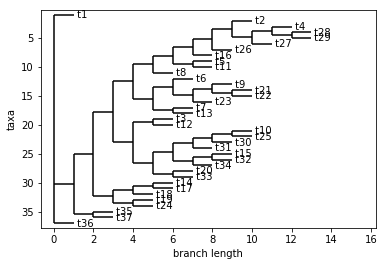

In [47]:
Phylo.draw(mytree)

### If no branch lengths

In [69]:
mytree = Tree("/Users/pmckenz1/Desktop/projects/quartet_proj/download_simseqs/relabeled_combined.tre")

In [70]:
alltipcombns = np.array(list(itertools.combinations((np.array(range(37))+1), 4)))

In [71]:
alltruequarts = np.empty(shape = (0,4))

for combo in range(len(alltipcombns)):

    # make an array of the pairwise distances in current quartet

    distmat= np.array(( #mytree.distance(("t"+str(alltipcombns[0][0])),("t"+str(alltipcombns[0][0]))),
                        mytree.get_distance((str(alltipcombns[combo][0])),(str(alltipcombns[combo][1]))),
                        mytree.get_distance((str(alltipcombns[combo][0])),(str(alltipcombns[combo][2]))),
                        mytree.get_distance((str(alltipcombns[combo][0])),(str(alltipcombns[combo][3]))),
                        #mytree.distance(("t"+str(alltipcombns[0][1])),("t"+str(alltipcombns[0][0]))),
                        #mytree.distance(("t"+str(alltipcombns[0][1])),("t"+str(alltipcombns[0][1]))),
                        mytree.get_distance((str(alltipcombns[combo][1])),(str(alltipcombns[combo][2]))),
                        mytree.get_distance((str(alltipcombns[combo][1])),(str(alltipcombns[combo][3]))),
                        #mytree.distance(("t"+str(alltipcombns[0][2])),("t"+str(alltipcombns[0][0]))),
                        #mytree.distance(("t"+str(alltipcombns[0][2])),("t"+str(alltipcombns[0][1]))),
                        #mytree.distance(("t"+str(alltipcombns[0][2])),("t"+str(alltipcombns[0][2]))),
                        mytree.get_distance((str(alltipcombns[combo][2])),(str(alltipcombns[combo][3]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][0]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][1]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][2]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][3])))) )
    ))

    # now select the closest two and group them against the other two.

    closest2 = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]][np.argmin(distmat)] # corresponds to each distance comparison
    truequartetidxs = closest2+list(set([0,1,2,3]) - set(closest2)) # make the true quartet
    truequartet = [alltipcombns[combo][i] for i in truequartetidxs]
    alltruequarts = np.vstack([alltruequarts,np.array(truequartet)])
alltruequarts = alltruequarts.astype(int)

### If branch lengths

In [25]:
alltruequarts = np.empty(shape = (0,4))

for combo in range(len(alltipcombns)):

    # make an array of the pairwise distances in current quartet

    distmat= np.array(( #mytree.distance(("t"+str(alltipcombns[0][0])),("t"+str(alltipcombns[0][0]))),
                        mytree.distance(("t"+str(alltipcombns[combo][0])),("t"+str(alltipcombns[combo][1]))),
                        mytree.distance(("t"+str(alltipcombns[combo][0])),("t"+str(alltipcombns[combo][2]))),
                        mytree.distance(("t"+str(alltipcombns[combo][0])),("t"+str(alltipcombns[combo][3]))),
                        #mytree.distance(("t"+str(alltipcombns[0][1])),("t"+str(alltipcombns[0][0]))),
                        #mytree.distance(("t"+str(alltipcombns[0][1])),("t"+str(alltipcombns[0][1]))),
                        mytree.distance(("t"+str(alltipcombns[combo][1])),("t"+str(alltipcombns[combo][2]))),
                        mytree.distance(("t"+str(alltipcombns[combo][1])),("t"+str(alltipcombns[combo][3]))),
                        #mytree.distance(("t"+str(alltipcombns[0][2])),("t"+str(alltipcombns[0][0]))),
                        #mytree.distance(("t"+str(alltipcombns[0][2])),("t"+str(alltipcombns[0][1]))),
                        #mytree.distance(("t"+str(alltipcombns[0][2])),("t"+str(alltipcombns[0][2]))),
                        mytree.distance(("t"+str(alltipcombns[combo][2])),("t"+str(alltipcombns[combo][3]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][0]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][1]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][2]))),
                        #mytree.distance(("t"+str(alltipcombns[0][3])),("t"+str(alltipcombns[0][3])))) )
    ))

    # now select the closest two and group them against the other two.

    closest2 = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]][np.argmin(distmat)] # corresponds to each distance comparison
    truequartetidxs = closest2+list(set([0,1,2,3]) - set(closest2)) # make the true quartet
    truequartet = [alltipcombns[combo][i] for i in truequartetidxs]
    alltruequarts = np.vstack([alltruequarts,np.array(truequartet)])
alltruequarts = alltruequarts.astype(int)

In [72]:
alltruequarts[0:10]

array([[ 2,  4,  1,  3],
       [ 2,  5,  1,  3],
       [ 1,  3,  2,  6],
       [ 1,  3,  2,  7],
       [ 2,  8,  1,  3],
       [ 1,  3,  2,  9],
       [ 1,  3,  2, 10],
       [ 2, 11,  1,  3],
       [ 3, 12,  1,  2],
       [ 1,  3,  2, 13]])

In [73]:
dump_qmc(quartets = alltruequarts,tempfiledir= "download_simseqs/")

### if "t[number]" tip names

In [33]:
_run_qmc(tempfiledir = "download_simseqs/", 
         tempfilename="download_simseqs/quartets.txt",
         treename="simtreeTRUE.phy",
         tipnames=["t" + str(i+1) for i in range(37)])

### if [number] tip names

In [74]:
_run_qmc(tempfiledir = "download_simseqs/", 
         tempfilename="download_simseqs/quartets.txt",
         treename="simtreeTRUE.phy",
         tipnames=[str(i+1) for i in range(37)])

## NEW: Properly decompose quartets for training

In [4]:
def decompose_to_quartets(tre):

    ## set to compared ordered sets, and set to store quartet
    qrts = set()
    stored = set()

    ## get all tips in tree as a set
    n_all = set(tre.tree.get_leaf_names())

    ## traverse tree
    for node in tre.tree.traverse():
        ## skip root or tip nodes
        if not (node.is_root() or node.is_leaf()):

            ## get all tips below this node
            below = set(node.get_leaf_names())
            above = n_all - below

            ## get all combinations of 2 above and 2 below this node
            for qrt in get_all_combs(tre, above, below):

                ## add to quartet set
                sqrt = tuple(sorted(qrt))
                if sqrt not in qrts:
                    stored.add(qrt)
                    qrts.add(sqrt)

    ## store qrts  
    return stored
def get_all_combs(self, set1, set2, as_list=False):
    #qiter = (sorted(i) + sorted(j) for (i, j) in itertools.product(
    #            itertools.combinations(set1, 2), 
    #            itertools.combinations(set2, 2),
    #        ))
    qiter = (tuple(i+j) for (i, j) in itertools.product(
        itertools.combinations(set1, 2), 
        itertools.combinations(set2, 2),
    ))

    ## option to return as list 
    if as_list:
        return list(qiter)
    ## but returning as generator is more efficient
    else:
        return qiter


## Generate a bunch of random trees, run seq-gen

In [139]:
for i in (np.array(range(25000))+1):
    simtree = treesim.birth_death_tree(birth_rate=1,death_rate=.6,birth_rate_sd=.2,death_rate_sd=.2,num_extant_tips =37)
    with open(("random_trees/samp"+str(i)+".tre"), "w") as text_file:
        text_file.write(simtree.as_string("newick")[5:]) #the simtree string contains annoying prefix chars that we skip

In [140]:
for i in (np.array(range(25000))+1):
    sshproc = subprocess.Popen(["seq-gen -m GTR -l"+str(int(np.random.choice(range(300,1000),1)))+" -n1 -z12345 -d"+str((abs(round(np.random.normal(.45,.2),2)))+.05)+" -wr < /Users/pmckenz1/Desktop/projects/quartet_proj/random_trees/samp"+str(i)+".tre > /Users/pmckenz1/Desktop/projects/quartet_proj/tree_seqs/test"+str(i)+".dat"],
                            shell=True,
                            stdout=subprocess.PIPE,
                            stderr=subprocess.STDOUT,
                            )

    output = sshproc.communicate()


In [13]:
output

('Sequence Generator - seq-gen\nVersion 1.3.4\n(c) Copyright, 1996-2017 Andrew Rambaut and Nick Grassly\nInstitute of Evolutionary Biology, University of Edinburgh\n\nOriginally developed at:\nDepartment of Zoology, University of Oxford\n\nRandom number generator seed: 12345\n\nSimulations of 37 taxa, 10000 nucleotides\n  for 1 tree(s) with 1 dataset(s) per tree\n\nBranch lengths of trees scaled so that tree is 1 from root to tip\n\nRate homogeneity of sites.\nModel = GTR: General time reversible (nucleotides)\n  Rate of transitions and transversions equal:\n  rate matrix = gamma1: 1.0000 alpha1: 1.0000  beta1: 1.0000\n                                beta2: 1.0000 alpha2: 1.0000\n                                              gamma2:  1.0000\n  with nucleotide frequencies equal.\nRelative rates for each site:\n1\t0.219546\n2\t0.219546\n3\t0.219546\n4\t0.219546\n5\t0.219546\n6\t0.219546\n7\t0.219546\n8\t0.219546\n9\t0.219546\n10\t0.219546\n11\t0.219546\n12\t0.219546\n13\t0.219546\n14\t0.

In [2]:
import copy

In [141]:
images = []
labels = []
for treenum in range(25000):
    thetree = toytree.tree('random_trees/samp'+str(treenum+1)+'.tre')
    treeqrts = list(decompose_to_quartets(thetree))
    fname = ('tree_seqs/test'+str(treenum+1)+'.dat')
    with open(fname) as f:
        sequences = f.readlines()

    # remove whitespace characters like `\n` at the end of each line

    sequences = [x.strip() for x in sequences] 
    sequences.pop(0)

    # get sequences  and identify quintet taxa
    names = [sequences[i][0:10].strip(" ") for i in range(len(sequences))]
    iso_sequences = [sequences[i][10:].strip(" ") for i in range(len(sequences))]
    
    for qrtnum in list((np.random.choice(range(len(treeqrts)),1))):
        true_qrt = np.array(treeqrts[qrtnum])
        tipnames = copy.deepcopy(true_qrt)
        np.random.shuffle(tipnames)
        # is correct config of these tips [0123],[0213], or [0312]
        correct_config = [int( ((set([tipnames[i] for i in q[0:2]]) == set(true_qrt[0:2])) or (set([tipnames[i] for i in q[0:2]]) == set(true_qrt[2:4]))) ) for q in [[0,1,2,3],[0,2,1,3],[0,3,1,2]]]
        # so we're only testing one possible quartet per tree... Easy to expand this to test every quintet per tree
        interestednames = tipnames # this should be a list of four tip names... e.g. ["t1","t2","t3","t4]
        taxa_ids = list(itertools.chain.from_iterable([list(compress(range(len(names)),i)) for i in [[q == i for i in names] for q in interestednames]]))

        tempobj = [iso_sequences[i] for i in taxa_ids]

        # eliminate non-snps

        ind_samples = []
        for i in range(len(tempobj[0])):
            currentbase = ([tempobj[q][i] for q in range(len(tempobj))])
            if (len(set(currentbase)) > 1):
                ind_samples.append(currentbase)
        ind_samples_reset = ind_samples

        # separate sequences by fifth taxon

        ind_samples = np.array(ind_samples_reset)
        ind_samples = np.where(ind_samples=='A',0,ind_samples)
        ind_samples = np.where(ind_samples=='C',1,ind_samples)
        ind_samples = np.where(ind_samples=='G',2,ind_samples)
        ind_samples = np.where(ind_samples=='T',3,ind_samples)
        ind_samples = ind_samples.astype(int)

        # get the matrices
        indexmat = np.array(range(16))
        indexmat.shape=(4,4)
        # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
        fullmat0123 = np.zeros(shape=(16,16))
        arr0123 = ind_samples
        for i in range(len(arr0123)):
                    # get row number 
            rownum = int(indexmat[arr0123[i][0],arr0123[i][1]])
                    # get col number
            colnum = int(indexmat[arr0123[i][2],arr0123[i][3]])
            fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1
        images.append(fullmat0123.flatten()/max(fullmat0123.flatten()))
        labels.append(correct_config)
    print treenum

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/Users/pmckenz1/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/pmckenz1/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/pmckenz1/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:45: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/pmckenz1/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/pmckenz1/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in divide


1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349
1350
1351
1352
1353
1354
1355
1356
1357
1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384
1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442
1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503


2943
2944
2945
2946
2947
2948
2949
2950
2951
2952
2953
2954
2955
2956
2957
2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971
2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994
2995
2996
2997
2998
2999
3000
3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034
3035
3036
3037
3038
3039
3040
3041
3042
3043
3044
3045
3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072
3073
3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085
3086
3087
3088
3089
3090
3091
3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142


4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781


6221
6222
6223
6224
6225
6226
6227
6228
6229
6230
6231
6232
6233
6234
6235
6236
6237
6238
6239
6240
6241
6242
6243
6244
6245
6246
6247
6248
6249
6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260
6261
6262
6263
6264
6265
6266
6267
6268
6269
6270
6271
6272
6273
6274
6275
6276
6277
6278
6279
6280
6281
6282
6283
6284
6285
6286
6287
6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299
6300
6301
6302
6303
6304
6305
6306
6307
6308
6309
6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323
6324
6325
6326
6327
6328
6329
6330
6331
6332
6333
6334
6335
6336
6337
6338
6339
6340
6341
6342
6343
6344
6345
6346
6347
6348
6349
6350
6351
6352
6353
6354
6355
6356
6357
6358
6359
6360
6361
6362
6363
6364
6365
6366
6367
6368
6369
6370
6371
6372
6373
6374
6375
6376
6377
6378
6379
6380
6381
6382
6383
6384
6385
6386
6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419
6420


7860
7861
7862
7863
7864
7865
7866
7867
7868
7869
7870
7871
7872
7873
7874
7875
7876
7877
7878
7879
7880
7881
7882
7883
7884
7885
7886
7887
7888
7889
7890
7891
7892
7893
7894
7895
7896
7897
7898
7899
7900
7901
7902
7903
7904
7905
7906
7907
7908
7909
7910
7911
7912
7913
7914
7915
7916
7917
7918
7919
7920
7921
7922
7923
7924
7925
7926
7927
7928
7929
7930
7931
7932
7933
7934
7935
7936
7937
7938
7939
7940
7941
7942
7943
7944
7945
7946
7947
7948
7949
7950
7951
7952
7953
7954
7955
7956
7957
7958
7959
7960
7961
7962
7963
7964
7965
7966
7967
7968
7969
7970
7971
7972
7973
7974
7975
7976
7977
7978
7979
7980
7981
7982
7983
7984
7985
7986
7987
7988
7989
7990
7991
7992
7993
7994
7995
7996
7997
7998
7999
8000
8001
8002
8003
8004
8005
8006
8007
8008
8009
8010
8011
8012
8013
8014
8015
8016
8017
8018
8019
8020
8021
8022
8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034
8035
8036
8037
8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059


9499
9500
9501
9502
9503
9504
9505
9506
9507
9508
9509
9510
9511
9512
9513
9514
9515
9516
9517
9518
9519
9520
9521
9522
9523
9524
9525
9526
9527
9528
9529
9530
9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9541
9542
9543
9544
9545
9546
9547
9548
9549
9550
9551
9552
9553
9554
9555
9556
9557
9558
9559
9560
9561
9562
9563
9564
9565
9566
9567
9568
9569
9570
9571
9572
9573
9574
9575
9576
9577
9578
9579
9580
9581
9582
9583
9584
9585
9586
9587
9588
9589
9590
9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602
9603
9604
9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9615
9616
9617
9618
9619
9620
9621
9622
9623
9624
9625
9626
9627
9628
9629
9630
9631
9632
9633
9634
9635
9636
9637
9638
9639
9640
9641
9642
9643
9644
9645
9646
9647
9648
9649
9650
9651
9652
9653
9654
9655
9656
9657
9658
9659
9660
9661
9662
9663
9664
9665
9666
9667
9668
9669
9670
9671
9672
9673
9674
9675
9676
9677
9678
9679
9680
9681
9682
9683
9684
9685
9686
9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698


10948
10949
10950
10951
10952
10953
10954
10955
10956
10957
10958
10959
10960
10961
10962
10963
10964
10965
10966
10967
10968
10969
10970
10971
10972
10973
10974
10975
10976
10977
10978
10979
10980
10981
10982
10983
10984
10985
10986
10987
10988
10989
10990
10991
10992
10993
10994
10995
10996
10997
10998
10999
11000
11001
11002
11003
11004
11005
11006
11007
11008
11009
11010
11011
11012
11013
11014
11015
11016
11017
11018
11019
11020
11021
11022
11023
11024
11025
11026
11027
11028
11029
11030
11031
11032
11033
11034
11035
11036
11037
11038
11039
11040
11041
11042
11043
11044
11045
11046
11047
11048
11049
11050
11051
11052
11053
11054
11055
11056
11057
11058
11059
11060
11061
11062
11063
11064
11065
11066
11067
11068
11069
11070
11071
11072
11073
11074
11075
11076
11077
11078
11079
11080
11081
11082
11083
11084
11085
11086
11087
11088
11089
11090
11091
11092
11093
11094
11095
11096
11097
11098
11099
11100
11101
11102
11103
11104
11105
11106
11107
11108
11109
11110
11111
11112
11113
1111

12314
12315
12316
12317
12318
12319
12320
12321
12322
12323
12324
12325
12326
12327
12328
12329
12330
12331
12332
12333
12334
12335
12336
12337
12338
12339
12340
12341
12342
12343
12344
12345
12346
12347
12348
12349
12350
12351
12352
12353
12354
12355
12356
12357
12358
12359
12360
12361
12362
12363
12364
12365
12366
12367
12368
12369
12370
12371
12372
12373
12374
12375
12376
12377
12378
12379
12380
12381
12382
12383
12384
12385
12386
12387
12388
12389
12390
12391
12392
12393
12394
12395
12396
12397
12398
12399
12400
12401
12402
12403
12404
12405
12406
12407
12408
12409
12410
12411
12412
12413
12414
12415
12416
12417
12418
12419
12420
12421
12422
12423
12424
12425
12426
12427
12428
12429
12430
12431
12432
12433
12434
12435
12436
12437
12438
12439
12440
12441
12442
12443
12444
12445
12446
12447
12448
12449
12450
12451
12452
12453
12454
12455
12456
12457
12458
12459
12460
12461
12462
12463
12464
12465
12466
12467
12468
12469
12470
12471
12472
12473
12474
12475
12476
12477
12478
12479
1248

13680
13681
13682
13683
13684
13685
13686
13687
13688
13689
13690
13691
13692
13693
13694
13695
13696
13697
13698
13699
13700
13701
13702
13703
13704
13705
13706
13707
13708
13709
13710
13711
13712
13713
13714
13715
13716
13717
13718
13719
13720
13721
13722
13723
13724
13725
13726
13727
13728
13729
13730
13731
13732
13733
13734
13735
13736
13737
13738
13739
13740
13741
13742
13743
13744
13745
13746
13747
13748
13749
13750
13751
13752
13753
13754
13755
13756
13757
13758
13759
13760
13761
13762
13763
13764
13765
13766
13767
13768
13769
13770
13771
13772
13773
13774
13775
13776
13777
13778
13779
13780
13781
13782
13783
13784
13785
13786
13787
13788
13789
13790
13791
13792
13793
13794
13795
13796
13797
13798
13799
13800
13801
13802
13803
13804
13805
13806
13807
13808
13809
13810
13811
13812
13813
13814
13815
13816
13817
13818
13819
13820
13821
13822
13823
13824
13825
13826
13827
13828
13829
13830
13831
13832
13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
1384

15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
15059
15060
15061
15062
15063
15064
15065
15066
15067
15068
15069
15070
15071
15072
15073
15074
15075
15076
15077
15078
15079
15080
15081
15082
15083
15084
15085
15086
15087
15088
15089
15090
15091
15092
15093
15094
15095
15096
15097
15098
15099
15100
15101
15102
15103
15104
15105
15106
15107
15108
15109
15110
15111
15112
15113
15114
15115
15116
15117
15118
15119
15120
15121
15122
15123
15124
15125
15126
15127
15128
15129
15130
15131
15132
15133
15134
15135
15136
15137
15138
15139
15140
15141
15142
15143
15144
15145
15146
15147
15148
15149
15150
15151
15152
15153
15154
15155
15156
15157
15158
15159
15160
15161
15162
15163
15164
15165
15166
15167
15168
15169
15170
15171
15172
15173
15174
15175
15176
15177
15178
15179
15180
15181
15182
15183
15184
15185
15186
15187
15188
15189
15190
15191
15192
15193
15194
15195
15196
15197
15198
15199
15200
15201
15202
15203
15204
15205
15206
15207
15208
15209
15210
15211
1521

16412
16413
16414
16415
16416
16417
16418
16419
16420
16421
16422
16423
16424
16425
16426
16427
16428
16429
16430
16431
16432
16433
16434
16435
16436
16437
16438
16439
16440
16441
16442
16443
16444
16445
16446
16447
16448
16449
16450
16451
16452
16453
16454
16455
16456
16457
16458
16459
16460
16461
16462
16463
16464
16465
16466
16467
16468
16469
16470
16471
16472
16473
16474
16475
16476
16477
16478
16479
16480
16481
16482
16483
16484
16485
16486
16487
16488
16489
16490
16491
16492
16493
16494
16495
16496
16497
16498
16499
16500
16501
16502
16503
16504
16505
16506
16507
16508
16509
16510
16511
16512
16513
16514
16515
16516
16517
16518
16519
16520
16521
16522
16523
16524
16525
16526
16527
16528
16529
16530
16531
16532
16533
16534
16535
16536
16537
16538
16539
16540
16541
16542
16543
16544
16545
16546
16547
16548
16549
16550
16551
16552
16553
16554
16555
16556
16557
16558
16559
16560
16561
16562
16563
16564
16565
16566
16567
16568
16569
16570
16571
16572
16573
16574
16575
16576
16577
1657

17778
17779
17780
17781
17782
17783
17784
17785
17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797
17798
17799
17800
17801
17802
17803
17804
17805
17806
17807
17808
17809
17810
17811
17812
17813
17814
17815
17816
17817
17818
17819
17820
17821
17822
17823
17824
17825
17826
17827
17828
17829
17830
17831
17832
17833
17834
17835
17836
17837
17838
17839
17840
17841
17842
17843
17844
17845
17846
17847
17848
17849
17850
17851
17852
17853
17854
17855
17856
17857
17858
17859
17860
17861
17862
17863
17864
17865
17866
17867
17868
17869
17870
17871
17872
17873
17874
17875
17876
17877
17878
17879
17880
17881
17882
17883
17884
17885
17886
17887
17888
17889
17890
17891
17892
17893
17894
17895
17896
17897
17898
17899
17900
17901
17902
17903
17904
17905
17906
17907
17908
17909
17910
17911
17912
17913
17914
17915
17916
17917
17918
17919
17920
17921
17922
17923
17924
17925
17926
17927
17928
17929
17930
17931
17932
17933
17934
17935
17936
17937
17938
17939
17940
17941
17942
17943
1794

19144
19145
19146
19147
19148
19149
19150
19151
19152
19153
19154
19155
19156
19157
19158
19159
19160
19161
19162
19163
19164
19165
19166
19167
19168
19169
19170
19171
19172
19173
19174
19175
19176
19177
19178
19179
19180
19181
19182
19183
19184
19185
19186
19187
19188
19189
19190
19191
19192
19193
19194
19195
19196
19197
19198
19199
19200
19201
19202
19203
19204
19205
19206
19207
19208
19209
19210
19211
19212
19213
19214
19215
19216
19217
19218
19219
19220
19221
19222
19223
19224
19225
19226
19227
19228
19229
19230
19231
19232
19233
19234
19235
19236
19237
19238
19239
19240
19241
19242
19243
19244
19245
19246
19247
19248
19249
19250
19251
19252
19253
19254
19255
19256
19257
19258
19259
19260
19261
19262
19263
19264
19265
19266
19267
19268
19269
19270
19271
19272
19273
19274
19275
19276
19277
19278
19279
19280
19281
19282
19283
19284
19285
19286
19287
19288
19289
19290
19291
19292
19293
19294
19295
19296
19297
19298
19299
19300
19301
19302
19303
19304
19305
19306
19307
19308
19309
1931

20510
20511
20512
20513
20514
20515
20516
20517
20518
20519
20520
20521
20522
20523
20524
20525
20526
20527
20528
20529
20530
20531
20532
20533
20534
20535
20536
20537
20538
20539
20540
20541
20542
20543
20544
20545
20546
20547
20548
20549
20550
20551
20552
20553
20554
20555
20556
20557
20558
20559
20560
20561
20562
20563
20564
20565
20566
20567
20568
20569
20570
20571
20572
20573
20574
20575
20576
20577
20578
20579
20580
20581
20582
20583
20584
20585
20586
20587
20588
20589
20590
20591
20592
20593
20594
20595
20596
20597
20598
20599
20600
20601
20602
20603
20604
20605
20606
20607
20608
20609
20610
20611
20612
20613
20614
20615
20616
20617
20618
20619
20620
20621
20622
20623
20624
20625
20626
20627
20628
20629
20630
20631
20632
20633
20634
20635
20636
20637
20638
20639
20640
20641
20642
20643
20644
20645
20646
20647
20648
20649
20650
20651
20652
20653
20654
20655
20656
20657
20658
20659
20660
20661
20662
20663
20664
20665
20666
20667
20668
20669
20670
20671
20672
20673
20674
20675
2067

21876
21877
21878
21879
21880
21881
21882
21883
21884
21885
21886
21887
21888
21889
21890
21891
21892
21893
21894
21895
21896
21897
21898
21899
21900
21901
21902
21903
21904
21905
21906
21907
21908
21909
21910
21911
21912
21913
21914
21915
21916
21917
21918
21919
21920
21921
21922
21923
21924
21925
21926
21927
21928
21929
21930
21931
21932
21933
21934
21935
21936
21937
21938
21939
21940
21941
21942
21943
21944
21945
21946
21947
21948
21949
21950
21951
21952
21953
21954
21955
21956
21957
21958
21959
21960
21961
21962
21963
21964
21965
21966
21967
21968
21969
21970
21971
21972
21973
21974
21975
21976
21977
21978
21979
21980
21981
21982
21983
21984
21985
21986
21987
21988
21989
21990
21991
21992
21993
21994
21995
21996
21997
21998
21999
22000
22001
22002
22003
22004
22005
22006
22007
22008
22009
22010
22011
22012
22013
22014
22015
22016
22017
22018
22019
22020
22021
22022
22023
22024
22025
22026
22027
22028
22029
22030
22031
22032
22033
22034
22035
22036
22037
22038
22039
22040
22041
2204

23242
23243
23244
23245
23246
23247
23248
23249
23250
23251
23252
23253
23254
23255
23256
23257
23258
23259
23260
23261
23262
23263
23264
23265
23266
23267
23268
23269
23270
23271
23272
23273
23274
23275
23276
23277
23278
23279
23280
23281
23282
23283
23284
23285
23286
23287
23288
23289
23290
23291
23292
23293
23294
23295
23296
23297
23298
23299
23300
23301
23302
23303
23304
23305
23306
23307
23308
23309
23310
23311
23312
23313
23314
23315
23316
23317
23318
23319
23320
23321
23322
23323
23324
23325
23326
23327
23328
23329
23330
23331
23332
23333
23334
23335
23336
23337
23338
23339
23340
23341
23342
23343
23344
23345
23346
23347
23348
23349
23350
23351
23352
23353
23354
23355
23356
23357
23358
23359
23360
23361
23362
23363
23364
23365
23366
23367
23368
23369
23370
23371
23372
23373
23374
23375
23376
23377
23378
23379
23380
23381
23382
23383
23384
23385
23386
23387
23388
23389
23390
23391
23392
23393
23394
23395
23396
23397
23398
23399
23400
23401
23402
23403
23404
23405
23406
23407
2340

24608
24609
24610
24611
24612
24613
24614
24615
24616
24617
24618
24619
24620
24621
24622
24623
24624
24625
24626
24627
24628
24629
24630
24631
24632
24633
24634
24635
24636
24637
24638
24639
24640
24641
24642
24643
24644
24645
24646
24647
24648
24649
24650
24651
24652
24653
24654
24655
24656
24657
24658
24659
24660
24661
24662
24663
24664
24665
24666
24667
24668
24669
24670
24671
24672
24673
24674
24675
24676
24677
24678
24679
24680
24681
24682
24683
24684
24685
24686
24687
24688
24689
24690
24691
24692
24693
24694
24695
24696
24697
24698
24699
24700
24701
24702
24703
24704
24705
24706
24707
24708
24709
24710
24711
24712
24713
24714
24715
24716
24717
24718
24719
24720
24721
24722
24723
24724
24725
24726
24727
24728
24729
24730
24731
24732
24733
24734
24735
24736
24737
24738
24739
24740
24741
24742
24743
24744
24745
24746
24747
24748
24749
24750
24751
24752
24753
24754
24755
24756
24757
24758
24759
24760
24761
24762
24763
24764
24765
24766
24767
24768
24769
24770
24771
24772
24773
2477

In [29]:
labels.pop(869)

[0, 0, 1]

In [144]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_image = tf.reshape(x, [-1, 16, 16, 1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([4* 4*64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 4*4*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 3])
b_fc2 = bias_variable([3])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(2000):
    batch = np.random.choice(22000, 200)
    batch_xs, batch_ys = np.array([images[q] for q in batch]),np.array([labels[q] for q in batch])
    if i % 100 == 0:
      train_accuracy = accuracy.eval(feed_dict={
          x: batch_xs, y_: batch_ys, keep_prob: 1.0})
      print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})

  print('test accuracy %g' % accuracy.eval(feed_dict={
      x: images[23000:25000], y_: labels[23000:25000], keep_prob: 1.0}))

step 0, training accuracy 0.31
step 100, training accuracy 0.32
step 200, training accuracy 0.335
step 300, training accuracy 0.36
step 400, training accuracy 0.26
step 500, training accuracy 0.31
step 600, training accuracy 0.405
step 700, training accuracy 0.315
step 800, training accuracy 0.33
step 900, training accuracy 0.3
step 1000, training accuracy 0.315
step 1100, training accuracy 0.325
step 1200, training accuracy 0.305
step 1300, training accuracy 0.3
step 1400, training accuracy 0.31
step 1500, training accuracy 0.335
step 1600, training accuracy 0.34
step 1700, training accuracy 0.285
step 1800, training accuracy 0.33
step 1900, training accuracy 0.325
test accuracy 0.34


In [145]:
import toyplot

In [147]:
toyplot.matrix(images[0].reshape(16,16))

(<toyplot.canvas.Canvas at 0x12cd11d10>,
 <toyplot.coordinates.Table at 0x11d323190>)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.0 0.0714285714286 0.0 0.0 0.928571428571 0.0 0.0 0.0 0.571428571429 0.0714285714286 0.0 0.0 0.785714285714 0.0 0.0714285714286 0.0 1 0.214285714286 0.142857142857 0.0 0.0 0.0 0.357142857143 0.0 0.0 0.0 0.0714285714286 0.0 0.0 0.0 0.0 0.0 0.0 2 0.0 0.0 0.214285714286 0.142857142857 0.0 0.0714285714286 0.0 0.0 0.0 0.0 0.428571428571 0.0 0.0 0.0714285714286 0.0 0.0 3 0.214285714286 0.0 0.0714285714286 0.5 0.0 0.0 0.0 0.0714285714286 0.0 0.0 0.0 0.142857142857 0.0 0.0 0.0 0.571428571429 4 0.5 0.0 0.0 0.0 0.214285714286 0.142857142857 0.0 0.0 0.0714285714286 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5 0.0 0.5 0.0 0.0 0.142857142857 0.0 0.0 0.0714285714286 0.0 0.214285714286 0.0 0.0 0.0 1.0 0.0 0.0 6 0.0 0.0 0.0714285714286 0.0 0.0 0.0 0.357142857143 0.0 0.0 0.0 0.5 0.0714285714286 0.0 0.0 0.0 0.0714285714286 7 0.0 0.0 0.0 0.0714285714286 0.0714285714286 0.0714285714286 0.0 0.285714285714 0.0 0.0 0.0 0.0 0.0 0.0 0.0714285714286 0.785714285714 8 0.714285714286 0.0 0.0 0.0 0.142857142857 0.0 0.0 0.0 0.357142857143 0.0 0.0714285714286 0.0 0.214285714286 0.0 0.0 0.0 9 0.0 0.0 0.0 0.0 0.0714285714286 0.428571428571 0.0714285714286 0.0714285714286 0.0714285714286 0.5 0.285714285714 0.0 0.0 0.0 0.0714285714286 0.0 10 0.0714285714286 0.0 0.857142857143 0.0 0.0 0.0 0.571428571429 0.0 0.142857142857 0.285714285714 0.0 0.0 0.0 0.0 0.642857142857 0.0 11 0.0 0.0 0.0 0.0714285714286 0.0 0.0 0.0 0.0 0.0714285714286 0.0 0.285714285714 0.285714285714 0.0 0.0 0.0 0.5 12 0.857142857143 0.0 0.0 0.0 0.142857142857 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.357142857143 0.0 0.0 0.142857142857 13 0.0 0.142857142857 0.0 0.0 0.0 0.285714285714 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.142857142857 0.0 0.0714285714286 14 0.0 0.0 0.285714285714 0.0714285714286 0.0 0.0 0.214285714286 0.0 0.0 0.0 0.142857142857 0.0 0.0 0.0 0.285714285714 0.0714285714286 15 0.0 0.0 0.0 0.642857142857 0.0714285714286 0.0 0.0 0.571428571429 0.0 0.0 0.0 0.428571428571 0.285714285714 0.214285714286 0.142857142857 0.0

In [164]:
toyplot.matrix(images[1].reshape(16,16))
toyplot.matrix(images[3].reshape(16,16))
toyplot.matrix(images[5].reshape(16,16))
toyplot.matrix(images[7].reshape(16,16))

(<toyplot.canvas.Canvas at 0x126728f10>,
 <toyplot.coordinates.Table at 0x126728b90>)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.0 0.533333333333 0.866666666667 0.733333333333 0.0 0.0 0.0 0.0 0.133333333333 0.0 0.0666666666667 0.0 0.0666666666667 0.0 0.0 0.0 1 0.6 0.333333333333 0.0666666666667 0.133333333333 0.0 0.0666666666667 0.0666666666667 0.0 0.0 0.0 0.0666666666667 0.0 0.0666666666667 0.0666666666667 0.0 0.0 2 0.466666666667 0.0 0.666666666667 0.2 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.0666666666667 0.0 0.0 0.0666666666667 0.0 3 0.466666666667 0.0 0.0666666666667 0.866666666667 0.0 0.0666666666667 0.0 0.0666666666667 0.0 0.0 0.0 0.133333333333 0.0 0.0666666666667 0.0 0.0666666666667 4 0.0666666666667 0.0 0.0 0.0666666666667 0.6 0.4 0.266666666667 0.0666666666667 0.0 0.0 0.0666666666667 0.0 0.0 0.0 0.0 0.0 5 0.0 0.0 0.0 0.0666666666667 0.466666666667 0.0 0.866666666667 1.0 0.0666666666667 0.0666666666667 0.0 0.0 0.0666666666667 0.0666666666667 0.0 0.0 6 0.0 0.0666666666667 0.0666666666667 0.0 0.0666666666667 0.8 0.333333333333 0.133333333333 0.0 0.0 0.0666666666667 0.0666666666667 0.0 0.0 0.0 0.0 7 0.0 0.0 0.0 0.0 0.333333333333 0.466666666667 0.0666666666667 0.4 0.0 0.0 0.0 0.133333333333 0.0 0.0 0.0 0.133333333333 8 0.0666666666667 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.4 0.2 0.466666666667 0.266666666667 0.0 0.0 0.0 0.0 9 0.0666666666667 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.266666666667 0.4 0.933333333333 0.2 0.0666666666667 0.0666666666667 0.0 0.0 10 0.0 0.0 0.0666666666667 0.0 0.0 0.0 0.0666666666667 0.133333333333 0.733333333333 0.4 0.0 0.266666666667 0.0 0.0666666666667 0.2 0.0 11 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.133333333333 0.133333333333 0.4 0.266666666667 0.0 0.0666666666667 0.0 0.0666666666667 12 0.0 0.0 0.0 0.0666666666667 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.133333333333 0.666666666667 0.266666666667 0.0 0.866666666667 13 0.0666666666667 0.0 0.0 0.0 0.0 0.0666666666667 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.666666666667 0.133333333333 0.466666666667 14 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.133333333333 0.2 0.333333333333 0.8 15 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0666666666667 0.0666666666667 0.0666666666667 0.0 0.733333333333 0.533333333333 0.8 0.0

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.0 0.666666666667 0.333333333333 0.166666666667 0.333333333333 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.333333333333 0.0 0.0 0.0 1 0.333333333333 0.666666666667 0.0 0.333333333333 0.0 0.0 0.0 0.166666666667 0.166666666667 0.0 0.0 0.0 0.0 0.166666666667 0.0 0.166666666667 2 1.0 0.0 0.166666666667 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0 3 0.833333333333 0.166666666667 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.333333333333 4 0.0 0.166666666667 0.0 0.0 0.0 0.333333333333 0.0 0.166666666667 0.0 0.0 0.0 0.0 0.166666666667 0.0 0.0 0.0 5 0.0 0.0 0.0 0.0 0.166666666667 0.0 0.333333333333 0.666666666667 0.0 0.5 0.0 0.0 0.0 0.166666666667 0.166666666667 0.0 6 0.166666666667 0.0 0.0 0.0 0.0 0.333333333333 0.166666666667 0.166666666667 0.166666666667 0.0 0.166666666667 0.0 0.0 0.0 0.166666666667 0.0 7 0.0 0.0 0.0 0.0 0.166666666667 0.0 0.166666666667 0.166666666667 0.0 0.0 0.0 0.0 0.166666666667 0.0 0.166666666667 0.166666666667 8 0.5 0.0 0.0 0.0 0.0 0.0 0.0 0.166666666667 0.0 0.0 0.5 0.0 0.0 0.0 0.0 0.0 9 0.0 0.0 0.0 0.0 0.0 0.166666666667 0.0 0.0 0.0 0.166666666667 0.666666666667 0.0 0.0 0.0 0.0 0.0 10 0.0 0.0 0.166666666667 0.0 0.0 0.0 0.166666666667 0.0 0.5 0.333333333333 0.0 0.666666666667 0.0 0.0 0.0 0.0 11 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.166666666667 0.166666666667 0.166666666667 0.0 0.0 0.0 0.333333333333 12 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 13 0.0 0.0 0.0 0.0 0.0 0.333333333333 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.333333333333 14 0.0 0.0 0.0 0.0 0.0 0.166666666667 0.0 0.0 0.0 0.0 0.166666666667 0.0 0.166666666667 0.166666666667 0.166666666667 0.333333333333 15 0.0 0.0 0.166666666667 0.333333333333 0.166666666667 0.0 0.0 0.333333333333 0.0 0.0 0.0 0.166666666667 0.666666666667 0.5 0.666666666667 0.0

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.0 0.333333333333 0.833333333333 0.75 0.0 0.0833333333333 0.0 0.166666666667 0.166666666667 0.0833333333333 0.0 0.0833333333333 0.0833333333333 0.0 0.0 0.0 1 0.0833333333333 0.333333333333 0.416666666667 0.25 0.0 0.25 0.0 0.0 0.0 0.166666666667 0.166666666667 0.0 0.0833333333333 0.0 0.0 0.0833333333333 2 0.666666666667 0.416666666667 0.5 0.416666666667 0.0 0.0 0.0 0.0833333333333 0.0833333333333 0.0 0.0 0.0 0.0 0.0 0.0833333333333 0.0 3 1.0 0.166666666667 0.25 0.75 0.0 0.166666666667 0.0 0.0833333333333 0.0 0.0833333333333 0.0 0.0833333333333 0.0833333333333 0.0833333333333 0.0 0.166666666667 4 0.0 0.0833333333333 0.0 0.0833333333333 0.5 0.583333333333 0.333333333333 0.5 0.166666666667 0.0833333333333 0.0 0.0 0.0 0.0 0.0833333333333 0.0833333333333 5 0.0 0.0 0.0 0.0833333333333 0.666666666667 0.0 0.416666666667 0.416666666667 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.166666666667 6 0.0 0.0833333333333 0.0 0.0 0.5 0.833333333333 0.583333333333 0.666666666667 0.0 0.0833333333333 0.0833333333333 0.0 0.0 0.0 0.0833333333333 0.0 7 0.0 0.0833333333333 0.0 0.0 0.333333333333 0.666666666667 0.416666666667 0.416666666667 0.0 0.0 0.0 0.0833333333333 0.0833333333333 0.0 0.0833333333333 0.0 8 0.0833333333333 0.0 0.0 0.0 0.0 0.0833333333333 0.0 0.0833333333333 0.25 0.166666666667 0.583333333333 0.25 0.0 0.0 0.0833333333333 0.0833333333333 9 0.0 0.0 0.0 0.0 0.0 0.0 0.25 0.0 0.833333333333 0.333333333333 0.5 0.416666666667 0.0 0.0833333333333 0.0833333333333 0.0833333333333 10 0.0833333333333 0.0 0.0833333333333 0.0 0.0833333333333 0.166666666667 0.0 0.0833333333333 0.5 0.5 0.0 0.583333333333 0.0 0.0 0.0 0.166666666667 11 0.0 0.0 0.0 0.0 0.0833333333333 0.0833333333333 0.0833333333333 0.0 0.5 0.333333333333 1.0 0.333333333333 0.0 0.0 0.0833333333333 0.0 12 0.0 0.0 0.0 0.166666666667 0.0 0.0833333333333 0.0833333333333 0.0 0.0833333333333 0.0 0.0 0.0 0.75 0.166666666667 0.333333333333 0.916666666667 13 0.0 0.0833333333333 0.0 0.0 0.0833333333333 0.0 0.0 0.0833333333333 0.0833333333333 0.0833333333333 0.0 0.0 0.333333333333 0.666666666667 0.25 0.5 14 0.0 0.0 0.0833333333333 0.0 0.0 0.0 0.0833333333333 0.0833333333333 0.0 0.0 0.0 0.0833333333333 0.416666666667 0.5 0.333333333333 0.666666666667 15 0.0 0.0 0.0833333333333 0.166666666667 0.0833333333333 0.0 0.0833333333333 0.0833333333333 0.0 0.0 0.0 0.0833333333333 0.75 0.333333333333 0.25 0.0

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.0 0.125 0.375 0.375 0.375 0.125 0.0 0.125 0.5 0.125 0.125 0.25 0.125 0.125 0.0 0.125 1 0.0 0.0 0.0 0.125 0.125 0.5 0.125 0.375 0.125 0.25 0.125 0.125 0.0 0.625 0.125 0.0 2 0.0 0.0 0.375 0.0 0.125 0.25 0.375 0.125 0.0 0.0 0.625 0.125 0.0 0.125 0.25 0.0 3 0.25 0.0 0.25 0.125 0.125 0.125 0.125 0.25 0.125 0.125 0.25 0.125 0.25 0.25 0.0 0.75 4 0.75 0.125 0.125 0.0 0.375 0.25 0.0 0.0 0.25 0.0 0.0 0.25 0.375 0.375 0.0 0.0 5 0.0 0.25 0.0 0.0 0.0 0.0 0.375 0.25 0.0 0.25 0.125 0.125 0.25 0.375 0.0 0.25 6 0.125 0.125 0.125 0.125 0.0 0.125 0.0 0.25 0.125 0.0 0.25 0.0 0.0 0.125 0.375 0.0 7 0.0 0.0 0.125 0.125 0.25 0.25 0.375 0.25 0.25 0.125 0.0 0.375 0.0 0.125 0.25 1.0 8 0.375 0.0 0.125 0.25 0.625 0.0 0.0 0.25 0.125 0.125 0.25 0.0 0.5 0.125 0.25 0.125 9 0.25 0.75 0.125 0.125 0.0 0.375 0.125 0.0 0.125 0.5 0.375 0.0 0.125 0.0 0.0 0.125 10 0.125 0.125 0.125 0.0 0.0 0.0 0.75 0.125 0.125 0.0 0.0 0.125 0.0 0.0 0.125 0.125 11 0.0 0.125 0.125 0.875 0.0 0.0 0.125 0.375 0.125 0.125 0.375 0.375 0.25 0.0 0.0 0.75 12 0.25 0.0 0.25 0.25 0.25 0.0 0.0 0.125 0.375 0.25 0.0 0.0 0.125 0.0 0.125 0.25 13 0.0 0.375 0.0 0.375 0.125 0.75 0.125 0.25 0.0 0.0 0.125 0.125 0.0 0.75 0.25 0.125 14 0.0 0.0 0.25 0.0 0.125 0.125 0.5 0.125 0.125 0.0 0.25 0.125 0.125 0.125 0.5 0.25 15 0.25 0.0 0.125 0.5 0.0 0.0 0.25 0.625 0.0 0.25 0.125 0.25 0.0 0.375 0.375 0.0

In [157]:
toyplot.matrix(images[2].reshape(16,16))
toyplot.matrix(images[4].reshape(16,16))

(<toyplot.canvas.Canvas at 0x1263b2890>,
 <toyplot.coordinates.Table at 0x126485910>)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.0 0.571428571429 0.428571428571 0.428571428571 0.285714285714 0.142857142857 0.285714285714 0.0 0.571428571429 0.0 0.142857142857 0.0 0.428571428571 0.0 0.0 0.428571428571 1 0.428571428571 0.0 0.0 0.0 0.0 0.285714285714 0.142857142857 0.0 0.0 0.0 0.0 0.0 0.142857142857 0.0 0.0 0.0 2 0.571428571429 0.142857142857 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.428571428571 0.0 0.0 0.0 0.0 0.142857142857 3 0.142857142857 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.142857142857 0.0 0.0 0.0 4 0.285714285714 0.0 0.0 0.0 0.0 0.428571428571 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5 0.428571428571 0.571428571429 0.0 0.0 0.428571428571 0.0 0.142857142857 0.142857142857 0.0 0.857142857143 0.428571428571 0.0 0.0 0.142857142857 0.0 0.142857142857 6 0.0 0.142857142857 0.0 0.0 0.0 0.285714285714 0.0 0.0 0.0 0.0 0.285714285714 0.0 0.0 0.0 0.0 0.0 7 0.0 0.0 0.0 0.0 0.0 0.571428571429 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 8 0.142857142857 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.285714285714 0.0 0.142857142857 0.0 0.0 0.0 9 0.0 0.0 0.0 0.0 0.0 0.571428571429 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 10 0.142857142857 0.0 1.0 0.285714285714 0.142857142857 0.142857142857 0.571428571429 0.0 0.285714285714 0.142857142857 0.0 0.142857142857 0.0 0.0 0.0 0.0 11 0.142857142857 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.142857142857 0.0 0.0 0.0 0.0 0.142857142857 12 0.428571428571 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.142857142857 0.0 0.142857142857 0.0 0.0 0.0 0.142857142857 0.142857142857 13 0.0 0.0 0.0 0.0 0.0 0.714285714286 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.285714285714 14 0.142857142857 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.142857142857 0.0 0.0 0.0 0.0 0.142857142857 0.0 0.285714285714 15 0.428571428571 0.285714285714 0.0 0.714285714286 0.0 0.285714285714 0.0 0.142857142857 0.0 0.142857142857 0.0 0.428571428571 0.285714285714 0.571428571429 0.857142857143 0.0

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.0 0.153846153846 0.307692307692 0.0769230769231 0.0769230769231 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0769230769231 0.0 0.0 0.0769230769231 1 0.0 0.0 0.0 0.0 0.0 0.769230769231 0.0 0.0 0.0769230769231 0.0 0.0 0.0 0.0 0.0 0.0 0.153846153846 2 0.0 0.0 0.0769230769231 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0769230769231 0.0 0.0769230769231 0.0 3 0.0769230769231 0.0 0.0 0.0 0.0 0.0769230769231 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.153846153846 0.0 0.615384615385 4 1.0 0.0 0.307692307692 0.0769230769231 0.0769230769231 0.0769230769231 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5 0.0 0.230769230769 0.0 0.0 0.0 0.0 0.384615384615 0.0769230769231 0.0 0.0769230769231 0.0 0.0 0.0 0.384615384615 0.0 0.0 6 0.0 0.0 0.0 0.0 0.0 0.153846153846 0.0769230769231 0.0 0.0 0.0 0.846153846154 0.0769230769231 0.0 0.0 0.0 0.0769230769231 7 0.0769230769231 0.0 0.0 0.0 0.0 0.0769230769231 0.0 0.0 0.0 0.0 0.0 0.0769230769231 0.0 0.0 0.0 0.769230769231 8 0.923076923077 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0769230769231 0.0 0.307692307692 0.0 0.0 0.0 0.0769230769231 0.0 9 0.0 0.0 0.0 0.0 0.0 0.846153846154 0.0 0.0 0.0 0.153846153846 0.153846153846 0.0 0.0 0.0769230769231 0.0 0.0 10 0.0 0.0 0.153846153846 0.0 0.0 0.0 0.0769230769231 0.0 0.0769230769231 0.0 0.0 0.230769230769 0.0 0.0769230769231 0.230769230769 0.0 11 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.153846153846 0.0 0.0 0.0 0.0769230769231 1.0 12 0.923076923077 0.0769230769231 0.0769230769231 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.153846153846 13 0.0 0.0 0.0 0.0 0.0 0.615384615385 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0769230769231 14 0.0 0.0 0.0 0.0 0.0 0.0 0.153846153846 0.0 0.0 0.0 0.615384615385 0.0 0.0 0.0 0.0 0.153846153846 15 0.0 0.0 0.0 0.230769230769 0.0769230769231 0.0769230769231 0.0769230769231 0.153846153846 0.0 0.0 0.0 0.153846153846 0.153846153846 0.384615384615 0.307692307692 0.0

In [169]:
toyplot.matrix(images[6].reshape(16,16))
toyplot.matrix(images[8].reshape(16,16))
toyplot.matrix(images[9].reshape(16,16))

(<toyplot.canvas.Canvas at 0x12699ba90>,
 <toyplot.coordinates.Table at 0x1263b2690>)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.0 0.0 0.125 0.25 0.125 0.0 0.0 0.0 0.625 0.0 0.0 0.0 0.5 0.0 0.0 0.0 1 0.75 0.0 0.0 0.0 0.375 0.0 0.0 0.0 0.375 0.125 0.125 0.0 0.25 0.0 0.0 0.0 2 1.0 0.0 0.125 0.0 0.25 0.125 0.0 0.0 0.5 0.0 0.0 0.25 0.375 0.0 0.0 0.125 3 0.625 0.0 0.0 0.0 0.25 0.125 0.0 0.0 0.25 0.0 0.125 0.0 0.375 0.0 0.0 0.0 4 0.0 0.25 0.0 0.0 0.0 0.5 0.0 0.0 0.125 0.125 0.125 0.0 0.0 0.625 0.0 0.0 5 0.25 0.5 0.125 0.0 0.125 0.0 0.125 0.0 0.0 0.125 0.125 0.0 0.0 0.5 0.0 0.25 6 0.125 0.25 0.0 0.0 0.0 0.5 0.125 0.0 0.125 0.0 0.125 0.0 0.0 0.625 0.125 0.0 7 0.0 0.25 0.125 0.0 0.0 0.75 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.5 0.0 0.0 8 0.0 0.0 0.375 0.0 0.0 0.25 0.125 0.0 0.125 0.0 0.75 0.0 0.0 0.0 0.0 0.125 9 0.0 0.0 0.375 0.0 0.0 0.0 0.0 0.125 0.0 0.0 0.75 0.0 0.0 0.0 0.375 0.0 10 0.0 0.125 0.875 0.0 0.0 0.125 0.375 0.0 0.125 0.0 0.0 0.25 0.125 0.0 0.25 0.25 11 0.0 0.0 0.125 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.75 0.0 0.0 0.125 0.625 0.0 12 0.0 0.0 0.0 0.25 0.0 0.0 0.125 0.0 0.0 0.0 0.0 0.625 0.125 0.125 0.0 0.75 13 0.375 0.0 0.0 0.25 0.125 0.125 0.0 0.125 0.125 0.0 0.0 0.25 0.0 0.0 0.0 0.75 14 0.125 0.0 0.0 0.125 0.0 0.125 0.0 0.25 0.0 0.0 0.375 0.5 0.125 0.0 0.125 0.625 15 0.0 0.125 0.0 0.625 0.0 0.0 0.0 0.25 0.0 0.0 0.0 0.5 0.0 0.0 0.0 0.0

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.0 0.3125 0.0 0.25 0.375 0.1875 0.0625 0.0 0.125 0.0625 0.125 0.0625 0.3125 0.125 0.0 0.1875 1 1.0 0.25 0.0625 0.0 0.3125 0.3125 0.0 0.0 0.125 0.0 0.0 0.0625 0.0625 0.0625 0.0 0.125 2 0.6875 0.0625 0.125 0.1875 0.0 0.0625 0.1875 0.125 0.1875 0.0625 0.1875 0.125 0.125 0.0 0.0 0.0 3 0.625 0.0625 0.125 0.125 0.0625 0.0625 0.125 0.125 0.0625 0.0 0.1875 0.125 0.25 0.1875 0.0 0.125 4 0.5625 0.1875 0.0 0.0 0.0 0.5 0.0 0.0625 0.125 0.125 0.0625 0.0 0.0625 0.0 0.0 0.125 5 0.0625 0.3125 0.0625 0.0 0.0625 0.0 0.375 0.3125 0.125 0.3125 0.0625 0.0625 0.1875 0.1875 0.0 0.0 6 0.0625 0.125 0.0625 0.0 0.125 0.875 0.0 0.0 0.125 0.1875 0.25 0.0625 0.0625 0.1875 0.0625 0.125 7 0.0 0.1875 0.0 0.0625 0.0 0.5 0.125 0.0625 0.0 0.0 0.0625 0.125 0.1875 0.125 0.125 0.1875 8 0.0 0.0625 0.3125 0.1875 0.0 0.0625 0.3125 0.0625 0.1875 0.0625 0.4375 0.1875 0.0 0.0625 0.25 0.125 9 0.0625 0.0 0.1875 0.0 0.0625 0.0625 0.0625 0.1875 0.25 0.125 0.625 0.1875 0.0 0.0 0.0625 0.25 10 0.125 0.0625 0.0625 0.0625 0.0625 0.0625 0.125 0.0 0.25 0.1875 0.0 0.25 0.0625 0.0625 0.25 0.0 11 0.0 0.0625 0.125 0.0 0.0 0.125 0.125 0.25 0.0 0.125 0.5 0.0625 0.125 0.0625 0.4375 0.125 12 0.3125 0.125 0.0 0.125 0.0 0.0625 0.0625 0.0625 0.0 0.0625 0.0 0.0 0.1875 0.0 0.125 0.5 13 0.0625 0.0 0.0 0.0625 0.125 0.1875 0.0625 0.1875 0.0625 0.0625 0.1875 0.1875 0.0 0.1875 0.0625 0.8125 14 0.125 0.0625 0.125 0.1875 0.0 0.1875 0.0 0.125 0.125 0.0 0.25 0.0625 0.375 0.0625 0.125 0.1875 15 0.125 0.0 0.0625 0.3125 0.0 0.3125 0.0625 0.375 0.0 0.0625 0.0625 0.4375 0.0625 0.3125 0.1875 0.0

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.0 0.333333333333 0.555555555556 0.666666666667 0.222222222222 0.0 0.0 0.0 0.333333333333 0.0 0.0 0.0 0.222222222222 0.0 0.0 0.111111111111 1 0.444444444444 0.0 0.0 0.0 0.111111111111 0.111111111111 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 2 0.222222222222 0.0 0.0 0.0 0.222222222222 0.0 0.0 0.0 0.111111111111 0.111111111111 0.444444444444 0.111111111111 0.0 0.0 0.0 0.0 3 0.333333333333 0.0 0.0 0.111111111111 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.222222222222 0.0 0.0 0.555555555556 4 0.222222222222 0.0 0.0 0.0 0.0 0.222222222222 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5 0.0 0.111111111111 0.0 0.0 0.777777777778 0.0 1.0 0.444444444444 0.0 0.444444444444 0.0 0.0 0.111111111111 0.555555555556 0.0 0.0 6 0.0 0.0 0.0 0.0 0.0 0.222222222222 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7 0.111111111111 0.0 0.0 0.0 0.0 0.222222222222 0.0 0.0 0.0 0.0 0.0 0.111111111111 0.0 0.0 0.0 0.333333333333 8 0.444444444444 0.0 0.111111111111 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.333333333333 0.0 0.0 0.0 0.0 0.0 9 0.0 0.0 0.0 0.0 0.111111111111 0.333333333333 0.0 0.111111111111 0.0 0.0 0.111111111111 0.0 0.0 0.111111111111 0.0 0.0 10 0.0 0.0 0.444444444444 0.111111111111 0.0 0.0 0.444444444444 0.0 0.555555555556 0.333333333333 0.0 0.666666666667 0.0 0.0 0.111111111111 0.0 11 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.333333333333 12 0.555555555556 0.0 0.0 0.222222222222 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.111111111111 0.0 0.222222222222 13 0.0 0.0 0.0 0.0 0.0 0.444444444444 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.555555555556 14 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.111111111111 0.111111111111 0.111111111111 0.0 0.0 0.0 0.222222222222 15 0.111111111111 0.111111111111 0.0 0.222222222222 0.0 0.0 0.111111111111 0.444444444444 0.0 0.0 0.0 0.111111111111 0.333333333333 0.444444444444 1.0 0.0

### Show that learning algorithm has a very easy image recognition problem

In [171]:
treenum = 0

thetree = toytree.tree('random_trees/samp'+str(treenum+1)+'.tre')
treeqrts = list(decompose_to_quartets(thetree))
fname = ('tree_seqs/test'+str(treenum+1)+'.dat')
with open(fname) as f:
    sequences = f.readlines()

# remove whitespace characters like `\n` at the end of each line

sequences = [x.strip() for x in sequences] 
sequences.pop(0)

# get sequences  and identify quintet taxa
names = [sequences[i][0:10].strip(" ") for i in range(len(sequences))]
iso_sequences = [sequences[i][10:].strip(" ") for i in range(len(sequences))]


### We can show that `treeqrts` contains the true quartets by looking at some examples on the tree (varying `num`)

In [216]:
num = 6

In [217]:
colors = [thetree.colors[0] if i==True else thetree.colors[1] \
          for i in [thetree.get_node_labels()[q] in treeqrts[num] for q in range(len(thetree.get_node_labels()))]]
thetree.draw(
    width=300,
    height = 490,
    node_labels=False, 
    node_color=colors,
    node_size=15,
);

T32 T12 T9 T34 T1 T10 T8 T29 T33 T37 T23 T7 T26 T18 T25 T21 T30 T15 T4 T16 T20 T28 T27 T5 T19 T2 T31 T3 T14 T24 T6 T36 T11 T35 T13 T22 T17 idx: 0
name: 0
dist: 2.82886582034
support: 100 idx: 1
name: 1
dist: 3.60498588216
support: 100 idx: 2
name: 2
dist: 0.316059732652
support: 100 idx: 3
name: 3
dist: 1.19188935088
support: 100 idx: 4
name: 4
dist: 0.494665360619
support: 100 idx: 5
name: 5
dist: 0.899638884233
support: 100 idx: 6
name: 6
dist: 0.619440413797
support: 100 idx: 7
name: 7
dist: 0.326471035887
support: 100 idx: 8
name: 8
dist: 0.535685265039
support: 100 idx: 9
name: 9
dist: 0.927372832016
support: 100 idx: 10
name: 10
dist: 0.131391887688
support: 100 idx: 11
name: 11
dist: 0.0848498569949
support: 100 idx: 12
name: 12
dist: 0.398242521002
support: 100 idx: 13
name: 13
dist: 0.0991349518347
support: 100 idx: 14
name: 14
dist: 0.607174369048
support: 100 idx: 15
name: 15
dist: 0.511751580032
support: 100 idx: 16
name: 16
dist: 1.23057241168
support: 100 idx: 17
name: 17
dist: 3.26343297436
support: 100 idx: 18
name: 18
dist: 0.0543180988013
support: 100 idx: 19
name: 19
dist: 0.401439940988
support: 100 idx: 20
name: 20
dist: 0.0184428772198
support: 100 idx: 21
name: 21
dist: 0.853620023316
support: 100 idx: 22
name: 22
dist: 1.07573885297
support: 100 idx: 23
name: 23
dist: 0.780369286849
support: 100 idx: 24
name: 24
dist: 0.624998060958
support: 100 idx: 25
name: 25
dist: 2.54068876361
support: 100 idx: 26
name: 26
dist: 1.35920924578
support: 100 idx: 27
name: 27
dist: 0.516059271355
support: 100 idx: 28
name: 28
dist: 0.507180048732
support: 100 idx: 29
name: 29
dist: 0.143434591556
support: 100 idx: 30
name: 30
dist: 0.475057391486
support: 100 idx: 31
name: 31
dist: 0.599502889101
support: 100 idx: 32
name: 32
dist: 0.0834410491688
support: 100 idx: 33
name: 33
dist: 0.0530795985656
support: 100 idx: 34
name: 34
dist: 0.180826280595
support: 100 idx: 35
name: 35
dist: 0.14599556348
support: 100 idx: 36
name: T32
dist: 2.90470811837
support: 100 idx: 37
name: T12
dist: 2.90470811837
support: 100 idx: 38
name: T9
dist: 2.02887850014
support: 100 idx: 39
name: T34
dist: 0.0151338414937
support: 100 idx: 40
name: T1
dist: 0.0151338414937
support: 100 idx: 41
name: T10
dist: 0.308103219404
support: 100 idx: 42
name: T8
dist: 0.308103219404
support: 100 idx: 43
name: T29
dist: 0.0711550424687
support: 100 idx: 44
name: T33
dist: 0.0711550424687
support: 100 idx: 45
name: T37
dist: 0.867135986797
support: 100 idx: 46
name: T23
dist: 0.384043608799
support: 100 idx: 47
name: T7
dist: 0.384043608799
support: 100 idx: 48
name: T26
dist: 0.0759768089193
support: 100 idx: 49
name: T18
dist: 0.0759768089193
support: 100 idx: 50
name: T25
dist: 0.171399597935
support: 100 idx: 51
name: T21
dist: 0.171399597935
support: 100 idx: 52
name: T30
dist: 2.33174834714
support: 100 idx: 53
name: T15
dist: 1.87599030735
support: 100 idx: 54
name: T4
dist: 1.87599030735
support: 100 idx: 55
name: T16
dist: 2.25898737112
support: 100 idx: 56
name: T20
dist: 0.329628494832
support: 100 idx: 57
name: T28
dist: 0.329628494832
support: 100 idx: 58
name: T27
dist: 0.624998060958
support: 100 idx: 59
name: T5
dist: 0.0
support: 100 idx: 60
name: T19
dist: 0.0
support: 100 idx: 61
name: T2
dist: 3.05449255789
support: 100 idx: 62
name: T31
dist: 1.17922404076
support: 100 idx: 63
name: T3
dist: 1.17922404076
support: 100 idx: 64
name: T14
dist: 1.18810326338
support: 100 idx: 65
name: T24
dist: 0.569611280338
support: 100 idx: 66
name: T6
dist: 0.569611280338
support: 100 idx: 67
name: T36
dist: 0.361724733553
support: 100 idx: 68
name: T11
dist: 0.361724733553
support: 100 idx: 69
name: T35
dist: 0.392086184157
support: 100 idx: 70
name: T13
dist: 0.211259903561
support: 100 idx: 71
name: T22
dist: 0.0652643400818
support: 100 idx: 72
name: T17
dist: 0.0652643400818
support: 100

In [218]:
treeqrts[num]

('T4', 'T5', 'T34', 'T32')

### Now get one of these quartets and look at it

In [281]:
treenum = np.random.choice(range(2000))+1

thetree = toytree.tree('random_trees/samp'+str(treenum+1)+'.tre')
treeqrts = list(decompose_to_quartets(thetree))
fname = ('tree_seqs/test'+str(treenum+1)+'.dat')
with open(fname) as f:
    sequences = f.readlines()

# remove whitespace characters like `\n` at the end of each line

sequences = [x.strip() for x in sequences] 
sequences.pop(0)

# get sequences  and identify quintet taxa
names = [sequences[i][0:10].strip(" ") for i in range(len(sequences))]
iso_sequences = [sequences[i][10:].strip(" ") for i in range(len(sequences))]

num = int((np.random.choice(range(len(treeqrts)),1)))
print "num = " + str(num)
colors = [thetree.colors[0] if i==True else thetree.colors[1] \
          for i in [thetree.get_node_labels()[q] in treeqrts[num] for q in range(len(thetree.get_node_labels()))]]
thetree.draw(
    width=300,
    height = 490,
    node_labels=False, 
    node_color=colors,
    node_size=15,
);
treeqrts[num]

num = 27061


('T32', 'T18', 'T34', 'T35')

T24 T1 T2 T33 T12 T28 T7 T11 T3 T16 T25 T18 T4 T15 T35 T26 T21 T9 T34 T22 T5 T37 T19 T23 T30 T36 T32 T10 T27 T8 T20 T6 T17 T29 T14 T31 T13 idx: 0
name: 0
dist: 2.9677532809
support: 100 idx: 1
name: 1
dist: 1.68994832875
support: 100 idx: 2
name: 2
dist: 3.68693223442
support: 100 idx: 3
name: 3
dist: 0.0441830563335
support: 100 idx: 4
name: 4
dist: 0.841682396092
support: 100 idx: 5
name: 5
dist: 0.474233072632
support: 100 idx: 6
name: 6
dist: 2.71722041605
support: 100 idx: 7
name: 7
dist: 1.15341089527
support: 100 idx: 8
name: 8
dist: 1.0644127166
support: 100 idx: 9
name: 9
dist: 0.647467570191
support: 100 idx: 10
name: 10
dist: 2.64388760481
support: 100 idx: 11
name: 11
dist: 0.256309258212
support: 100 idx: 12
name: 12
dist: 1.52022761576
support: 100 idx: 13
name: 13
dist: 0.142902742916
support: 100 idx: 14
name: 14
dist: 1.27675974999
support: 100 idx: 15
name: 15
dist: 3.36609436409
support: 100 idx: 16
name: 16
dist: 0.856393773743
support: 100 idx: 17
name: 17
dist: 0.668562643851
support: 100 idx: 18
name: 18
dist: 0.221175345367
support: 100 idx: 19
name: 19
dist: 0.59112078046
support: 100 idx: 20
name: 20
dist: 0.245529434498
support: 100 idx: 21
name: 21
dist: 0.307860542848
support: 100 idx: 22
name: 22
dist: 0.407467496406
support: 100 idx: 23
name: 23
dist: 0.758814141587
support: 100 idx: 24
name: 24
dist: 4.19497926283
support: 100 idx: 25
name: 25
dist: 0.788318192837
support: 100 idx: 26
name: 26
dist: 0.714065656954
support: 100 idx: 27
name: 27
dist: 1.96736153364
support: 100 idx: 28
name: 28
dist: 0.195986956513
support: 100 idx: 29
name: 29
dist: 0.509202967769
support: 100 idx: 30
name: 30
dist: 0.911725974745
support: 100 idx: 31
name: 31
dist: 1.68591019723
support: 100 idx: 32
name: 32
dist: 0.180238344215
support: 100 idx: 33
name: 33
dist: 0.94000807859
support: 100 idx: 34
name: 34
dist: 0.0274354518166
support: 100 idx: 35
name: 35
dist: 0.583942055057
support: 100 idx: 36
name: T24
dist: 4.72769062491
support: 100 idx: 37
name: T1
dist: 1.04075839049
support: 100 idx: 38
name: T2
dist: 1.04075839049
support: 100 idx: 39
name: T33
dist: 5.0575404286
support: 100 idx: 40
name: T12
dist: 2.34032001255
support: 100 idx: 41
name: T28
dist: 2.34032001255
support: 100 idx: 42
name: T7
dist: 4.37836260596
support: 100 idx: 43
name: T11
dist: 3.31394988936
support: 100 idx: 44
name: T3
dist: 0.0225947143533
support: 100 idx: 45
name: T16
dist: 0.0225947143533
support: 100 idx: 46
name: T25
dist: 2.41017306095
support: 100 idx: 47
name: T18
dist: 0.889945445197
support: 100 idx: 48
name: T4
dist: 0.889945445197
support: 100 idx: 49
name: T15
dist: 6.23055315441
support: 100 idx: 50
name: T35
dist: 0.731305266586
support: 100 idx: 51
name: T26
dist: 0.731305266586
support: 100 idx: 52
name: T21
dist: 0.919136396478
support: 100 idx: 53
name: T9
dist: 0.106840270652
support: 100 idx: 54
name: T34
dist: 0.106840270652
support: 100 idx: 55
name: T22
dist: 0.144571073765
support: 100 idx: 56
name: T5
dist: 0.144571073765
support: 100 idx: 57
name: T37
dist: 0.0449641202076
support: 100 idx: 58
name: T19
dist: 0.0449641202076
support: 100 idx: 59
name: T23
dist: 0.0
support: 100 idx: 60
name: T30
dist: 0.0
support: 100 idx: 61
name: T36
dist: 3.40666107
support: 100 idx: 62
name: T32
dist: 0.725233879401
support: 100 idx: 63
name: T10
dist: 0.529246922888
support: 100 idx: 64
name: T27
dist: 0.0200439551186
support: 100 idx: 65
name: T8
dist: 0.0200439551186
support: 100 idx: 66
name: T20
dist: 0.0949592410621
support: 100 idx: 67
name: T6
dist: 0.0949592410621
support: 100 idx: 68
name: T17
dist: 1.60063109408
support: 100 idx: 69
name: T29
dist: 0.633187563675
support: 100 idx: 70
name: T14
dist: 0.633187563675
support: 100 idx: 71
name: T31
dist: 0.0766809604351
support: 100 idx: 72
name: T13
dist: 0.0766809604351
support: 100

In [282]:
qrtnum = num
true_qrt = np.array(treeqrts[qrtnum])
tipnames = copy.deepcopy(true_qrt)
np.random.shuffle(tipnames)
# is correct config of these tips [0123],[0213], or [0312]
correct_config = [int( ((set([tipnames[i] for i in q[0:2]]) == set(true_qrt[0:2])) or (set([tipnames[i] for i in q[0:2]]) == set(true_qrt[2:4]))) ) for q in [[0,1,2,3],[0,2,1,3],[0,3,1,2]]]
print "The true quartet is: " + str(true_qrt)
print "The random configuration of this is: " + str(tipnames)
print "The correct configuration of the random configuration is: " + str([[0,1,2,3],[0,2,1,3], [0,3,1,2]][correct_config.index(1)])


The true quartet is: ['T32' 'T18' 'T34' 'T35']
The random configuration of this is: ['T18' 'T32' 'T35' 'T34']
The correct configuration of the random configuration is: [0, 1, 2, 3]


In [283]:
# so we're only testing one possible quartet per tree... Easy to expand this to test every quintet per tree
interestednames = tipnames # this should be a list of four tip names... e.g. ["t1","t2","t3","t4]
taxa_ids = list(itertools.chain.from_iterable([list(compress(range(len(names)),i)) for i in [[q == i for i in names] for q in interestednames]]))

tempobj = [iso_sequences[i] for i in taxa_ids]

# eliminate non-snps

ind_samples = []
for i in range(len(tempobj[0])):
    currentbase = ([tempobj[q][i] for q in range(len(tempobj))])
    if (len(set(currentbase)) > 1):
        ind_samples.append(currentbase)
ind_samples_reset = ind_samples

# separate sequences by fifth taxon

ind_samples = np.array(ind_samples_reset)
ind_samples = np.where(ind_samples=='A',0,ind_samples)
ind_samples = np.where(ind_samples=='C',1,ind_samples)
ind_samples = np.where(ind_samples=='G',2,ind_samples)
ind_samples = np.where(ind_samples=='T',3,ind_samples)
ind_samples = ind_samples.astype(int)


print(correct_config)
for q in [[0,1,2,3],[0,2,1,3],[0,3,1,2]]:
    # get the matrices
    indexmat = np.array(range(16))
    indexmat.shape=(4,4)
    # order across matrix is 00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
    fullmat0123 = np.zeros(shape=(16,16))
    arr0123 = ind_samples[:,q]
    for i in range(len(arr0123)):
                # get row number 
        rownum = int(indexmat[arr0123[i][0],arr0123[i][1]])
                # get col number
        colnum = int(indexmat[arr0123[i][2],arr0123[i][3]])
        fullmat0123[rownum,colnum] = fullmat0123[rownum,colnum] + 1
    #images.append(fullmat0123.flatten()/max(fullmat0123.flatten()))
    #labels.append(correct_config)
    toyplot.matrix((fullmat0123.flatten()/max(fullmat0123.flatten())).reshape(16,16))

[1, 0, 0]


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.0 0.133333333333 0.0 0.0 0.0666666666667 0.4 0.0 0.0 0.0666666666667 0.0 0.4 0.0 0.266666666667 0.0666666666667 0.0666666666667 0.4 1 0.666666666667 0.0 0.0666666666667 0.0666666666667 0.0666666666667 0.4 0.2 0.0 0.0 0.0 0.2 0.0 0.0666666666667 0.0 0.0666666666667 0.266666666667 2 0.4 0.0 0.133333333333 0.0 0.0 0.4 0.0 0.133333333333 0.0666666666667 0.0666666666667 0.6 0.0 0.0666666666667 0.0666666666667 0.266666666667 0.466666666667 3 0.466666666667 0.0666666666667 0.2 0.0666666666667 0.0666666666667 0.133333333333 0.0 0.0 0.0 0.0666666666667 0.333333333333 0.0666666666667 0.133333333333 0.0666666666667 0.133333333333 0.466666666667 4 0.533333333333 0.0 0.0666666666667 0.0 0.133333333333 0.733333333333 0.0666666666667 0.0 0.0 0.0666666666667 0.266666666667 0.0666666666667 0.0 0.0666666666667 0.0 0.0666666666667 5 0.466666666667 0.0666666666667 0.133333333333 0.2 0.333333333333 0.0 0.133333333333 0.0 0.0 0.266666666667 0.466666666667 0.0 0.0 0.133333333333 0.0666666666667 0.866666666667 6 0.4 0.0 0.0 0.0 0.0 0.466666666667 0.0666666666667 0.0 0.0 0.0 0.533333333333 0.0666666666667 0.0 0.0 0.0 0.133333333333 7 0.4 0.0 0.0 0.0666666666667 0.0666666666667 0.333333333333 0.0666666666667 0.0666666666667 0.0 0.133333333333 0.133333333333 0.0666666666667 0.0 0.0 0.0666666666667 0.6 8 0.666666666667 0.0 0.0 0.2 0.0666666666667 0.0666666666667 0.0 0.133333333333 0.0666666666667 0.133333333333 0.466666666667 0.0666666666667 0.0666666666667 0.0666666666667 0.0 0.0666666666667 9 0.333333333333 0.0666666666667 0.0 0.0 0.0 0.666666666667 0.133333333333 0.0 0.0 0.133333333333 0.4 0.0666666666667 0.0 0.0666666666667 0.0 0.466666666667 10 0.466666666667 0.0666666666667 0.0666666666667 0.0666666666667 0.0666666666667 0.4 0.2 0.0666666666667 0.0666666666667 0.133333333333 0.0 0.2 0.0666666666667 0.0 0.2 0.533333333333 11 0.333333333333 0.0666666666667 0.0 0.0 0.0 0.4 0.2 0.0666666666667 0.0 0.0 0.533333333333 0.0666666666667 0.133333333333 0.2 0.0666666666667 0.666666666667 12 1.0 0.133333333333 0.0 0.0 0.0666666666667 0.466666666667 0.0666666666667 0.0 0.0666666666667 0.133333333333 0.266666666667 0.0666666666667 0.0666666666667 0.0 0.0 0.466666666667 13 0.333333333333 0.133333333333 0.0 0.0 0.0 0.733333333333 0.0666666666667 0.0 0.0 0.0666666666667 0.333333333333 0.0666666666667 0.0 0.0666666666667 0.0 0.533333333333 14 0.2 0.0666666666667 0.133333333333 0.0 0.0 0.333333333333 0.0666666666667 0.0 0.2 0.0 0.933333333333 0.0666666666667 0.0 0.0666666666667 0.0666666666667 0.4 15 0.266666666667 0.0 0.0666666666667 0.133333333333 0.0 0.266666666667 0.0666666666667 0.2 0.0666666666667 0.0 0.466666666667 0.2 0.133333333333 0.2 0.266666666667 0.0

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.0 0.133333333333 0.0 0.0 0.666666666667 0.0 0.0666666666667 0.0666666666667 0.4 0.0 0.133333333333 0.0 0.466666666667 0.0666666666667 0.2 0.0666666666667 1 0.0666666666667 0.4 0.0 0.0 0.0666666666667 0.4 0.2 0.0 0.0 0.4 0.0 0.133333333333 0.0666666666667 0.133333333333 0.0 0.0 2 0.0666666666667 0.0 0.4 0.0 0.0 0.0 0.2 0.0 0.0666666666667 0.0666666666667 0.6 0.0 0.0 0.0666666666667 0.333333333333 0.0666666666667 3 0.266666666667 0.0666666666667 0.0666666666667 0.4 0.0666666666667 0.0 0.0666666666667 0.266666666667 0.0666666666667 0.0666666666667 0.266666666667 0.466666666667 0.133333333333 0.0666666666667 0.133333333333 0.466666666667 4 0.533333333333 0.0 0.0666666666667 0.0 0.466666666667 0.0666666666667 0.133333333333 0.2 0.4 0.0 0.0 0.0 0.4 0.0 0.0 0.0666666666667 5 0.133333333333 0.733333333333 0.0666666666667 0.0 0.333333333333 0.0 0.133333333333 0.0 0.0 0.466666666667 0.0666666666667 0.0 0.0666666666667 0.333333333333 0.0666666666667 0.0666666666667 6 0.0 0.0666666666667 0.266666666667 0.0666666666667 0.0 0.266666666667 0.466666666667 0.0 0.0 0.0 0.533333333333 0.0666666666667 0.0 0.133333333333 0.133333333333 0.0666666666667 7 0.0 0.0666666666667 0.0 0.0666666666667 0.0 0.133333333333 0.0666666666667 0.866666666667 0.0 0.0 0.0 0.133333333333 0.0 0.0 0.0666666666667 0.6 8 0.666666666667 0.0 0.0 0.2 0.333333333333 0.0666666666667 0.0 0.0 0.466666666667 0.0666666666667 0.0666666666667 0.0666666666667 0.333333333333 0.0666666666667 0.0 0.0 9 0.0666666666667 0.0666666666667 0.0 0.133333333333 0.0 0.666666666667 0.133333333333 0.0 0.0666666666667 0.4 0.2 0.0666666666667 0.0 0.4 0.2 0.0666666666667 10 0.0666666666667 0.133333333333 0.466666666667 0.0666666666667 0.0 0.133333333333 0.4 0.0666666666667 0.0666666666667 0.133333333333 0.0 0.2 0.0 0.0 0.533333333333 0.0666666666667 11 0.0666666666667 0.0666666666667 0.0 0.0666666666667 0.0 0.0666666666667 0.0 0.466666666667 0.0666666666667 0.0 0.2 0.533333333333 0.133333333333 0.2 0.0666666666667 0.666666666667 12 1.0 0.133333333333 0.0 0.0 0.333333333333 0.133333333333 0.0 0.0 0.2 0.0666666666667 0.133333333333 0.0 0.266666666667 0.0 0.0666666666667 0.133333333333 13 0.0666666666667 0.466666666667 0.0666666666667 0.0 0.0 0.733333333333 0.0666666666667 0.0 0.0 0.333333333333 0.0666666666667 0.0 0.0 0.266666666667 0.0666666666667 0.2 14 0.0666666666667 0.133333333333 0.266666666667 0.0666666666667 0.0 0.0666666666667 0.333333333333 0.0666666666667 0.2 0.0 0.933333333333 0.0666666666667 0.0666666666667 0.0 0.466666666667 0.2 15 0.0666666666667 0.0 0.0 0.466666666667 0.0 0.0666666666667 0.0 0.533333333333 0.0 0.0666666666667 0.0666666666667 0.4 0.133333333333 0.2 0.266666666667 0.0

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 0.0 0.0666666666667 0.0666666666667 0.266666666667 0.666666666667 0.0666666666667 0.0 0.0666666666667 0.4 0.0 0.0666666666667 0.0666666666667 0.466666666667 0.0666666666667 0.0 0.133333333333 1 0.133333333333 0.4 0.0 0.0666666666667 0.0 0.4 0.0 0.0 0.0 0.4 0.0666666666667 0.0666666666667 0.0666666666667 0.133333333333 0.0666666666667 0.0666666666667 2 0.0 0.0 0.4 0.0666666666667 0.0666666666667 0.2 0.2 0.0666666666667 0.133333333333 0.0 0.6 0.266666666667 0.2 0.0 0.333333333333 0.133333333333 3 0.0 0.0 0.0 0.4 0.0666666666667 0.0 0.0 0.266666666667 0.0 0.133333333333 0.0 0.466666666667 0.0666666666667 0.0 0.0666666666667 0.466666666667 4 0.533333333333 0.133333333333 0.0 0.0 0.466666666667 0.333333333333 0.0 0.0 0.4 0.0 0.0 0.0 0.4 0.0666666666667 0.0 0.0 5 0.0 0.733333333333 0.0666666666667 0.0666666666667 0.0666666666667 0.0 0.266666666667 0.133333333333 0.0 0.466666666667 0.0 0.0 0.0 0.333333333333 0.133333333333 0.0 6 0.0666666666667 0.0666666666667 0.266666666667 0.0 0.133333333333 0.133333333333 0.466666666667 0.0666666666667 0.0 0.0666666666667 0.533333333333 0.0 0.0 0.0666666666667 0.133333333333 0.0666666666667 7 0.0 0.0 0.0666666666667 0.0666666666667 0.2 0.0 0.0 0.866666666667 0.0 0.0 0.0666666666667 0.133333333333 0.0666666666667 0.0666666666667 0.0666666666667 0.6 8 0.666666666667 0.0666666666667 0.0666666666667 0.0666666666667 0.333333333333 0.0 0.0 0.0 0.466666666667 0.0666666666667 0.0666666666667 0.0666666666667 0.333333333333 0.0 0.0 0.133333333333 9 0.0 0.0666666666667 0.133333333333 0.0666666666667 0.0666666666667 0.666666666667 0.133333333333 0.0666666666667 0.0666666666667 0.4 0.133333333333 0.0 0.0666666666667 0.4 0.0 0.2 10 0.0 0.0 0.466666666667 0.0 0.0 0.133333333333 0.4 0.0 0.0666666666667 0.2 0.0 0.2 0.0 0.2 0.533333333333 0.0666666666667 11 0.2 0.133333333333 0.0666666666667 0.0666666666667 0.0 0.0 0.0666666666667 0.466666666667 0.0666666666667 0.0666666666667 0.2 0.533333333333 0.0 0.0666666666667 0.0666666666667 0.666666666667 12 1.0 0.0666666666667 0.0666666666667 0.0666666666667 0.333333333333 0.0 0.0 0.0 0.2 0.0 0.2 0.0 0.266666666667 0.0 0.0666666666667 0.133333333333 13 0.133333333333 0.466666666667 0.133333333333 0.0 0.133333333333 0.733333333333 0.0666666666667 0.0666666666667 0.0666666666667 0.333333333333 0.0 0.0666666666667 0.0 0.266666666667 0.0 0.2 14 0.0 0.0666666666667 0.266666666667 0.0 0.0 0.0666666666667 0.333333333333 0.0 0.133333333333 0.0666666666667 0.933333333333 0.0666666666667 0.0666666666667 0.0666666666667 0.466666666667 0.266666666667 15 0.0 0.0 0.0666666666667 0.466666666667 0.0 0.0 0.0666666666667 0.533333333333 0.0 0.0 0.0666666666667 0.4 0.133333333333 0.2 0.2 0.0